## Source of Data
- I used Amazon's own product advertising API as we need to obtain data from amazon.com using any programming language of our choice in a policy-compliant manner.
- I obtained data on women's tops and shirts and got data of approximately about 183000 products. We got data like Image-URL, Title, Price, Product Description, etc. So we will primarily focus on the data of women's tops.

## Importing packages

In [2]:
from tqdm import tqdm
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\esraj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
# loading the data
data = pd.read_json('tops_fashion.json')

In [42]:
print('Number of data points : ', data.shape[0],'\tNumber of features/variables:', data.shape[1])

Number of data points :  183138 	Number of features/variables: 19


In [43]:
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

## Selecting only 6 features out of 19

In [44]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [45]:
print ('Number of data points : ', data.shape[0],'\tNumber of features:', data.shape[1])
data.head()

Number of data points :  183138 	Number of features: 7


asin         brand              color  \
0  B016I2TS4W         FNC7C               None   
1  B01N49AI08  FIG Clothing               None   
2  B01JDPCOHO  FIG Clothing               None   
3  B01N19U5H5       Focal18               None   
4  B004GSI2OS   FeatherLite  Onyx Black/ Stone   

                                    medium_image_url product_type_name  \
0  https://images-na.ssl-images-amazon.com/images...             SHIRT   
1  https://images-na.ssl-images-amazon.com/images...             SHIRT   
2  https://images-na.ssl-images-amazon.com/images...             SHIRT   
3  https://images-na.ssl-images-amazon.com/images...             SHIRT   
4  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                               title formatted_price  
0  Minions Como Superheroes Ironman Long Sleeve R...            None  
1                      FIG Clothing Womens Izo Tunic            None  
2                        FIG Clothing Womens Won Top            None  
3  Focal18 Sailor Collar Bubble Sleeve Blouse Shi...            None  
4  Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26

## Checking Missing values in each feature

In [46]:
print(data['product_type_name'].describe())

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [47]:
# names of different product types
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [48]:
# find the 10 most frequent product_type_names.
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

In [49]:
# there are 10577 unique brands
print(data['brand'].describe())

# 183138 - 182987 = 151 missing values.

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [50]:
# Top 10 brands in our data
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

In [51]:
print(data['color'].describe())

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [52]:
# Top 10 colors
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

In [53]:
print(data['formatted_price'].describe())

# Only 28,395 (15.5% of whole data) products with price information

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [54]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

In [55]:
print(data['title'].describe())

# All of the products have a title. 
# Titles are fairly descriptive of what the product is. 
# We use titles extensively in this workshop 
# as they are short and informative.

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [56]:
# consider products which have price information
# data['formatted_price'].isnull() => gives the information 
# about the dataframe row's which have null values price == None|Null

data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

Number of data points After eliminating price=NULL : 28395


In [57]:
# consider products which have color information
# data['color'].isnull() => gives the information about the dataframe row's which have null values price == None|Null

data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

Number of data points After eliminating color=NULL : 28385


## Removing duplicate items

In [58]:
# find number of products that have duplicate titles.
print(sum(data.duplicated('title')))

2325


- We can observe that we have 2325 products which have same title but different color

In [59]:
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
11  B001LOUGE4                 Fitness Etc.              Black   
15  B003BSRPB0                  FeatherLite              White   
21  B014ICEDNA                        FNC7C             Purple   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
11  https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
21  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26  
6   Women's Unique 100% Cotton T - Special Olympic...           $9.99  
11             Ladies Cotton Tank 2x1 Ribbed Tank Top          $11.99  
15  FeatherLite Ladies' Moisture Free Mesh Sport S...          $20.54  
21  Supernatural Chibis Sam Dean And Castiel Short...           $7.50

In [60]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 27949


In [61]:
# Sort the whole data based on title (alphabetical order of title) 
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

asin     brand        color  \
61973   B06Y1KZ2WB    Éclair   Black/Pink   
133820  B010RV33VE  xiaoming         Pink   
81461   B01DDSDLNS  xiaoming        White   
75995   B00X5LYO9Y  xiaoming  Red Anchors   
151570  B00WPJG35K  xiaoming        White   

                                         medium_image_url product_type_name  \
61973   https://images-na.ssl-images-amazon.com/images...             SHIRT   
133820  https://images-na.ssl-images-amazon.com/images...             SHIRT   
81461   https://images-na.ssl-images-amazon.com/images...             SHIRT   
75995   https://images-na.ssl-images-amazon.com/images...             SHIRT   
151570  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                    title formatted_price  
61973   Éclair Women's Printed Thin Strap Blouse Black...          $24.99  
133820  xiaoming Womens Sleeveless Loose Long T-shirts...          $18.19  
81461   xiaoming Women's White Long Sleeve Single Brea...          $21.58  
75995   xiaoming Stripes Tank Patch/Bear Sleeve Anchor...          $15.91  
151570  xiaoming Sleeve Sheer Loose Tassel Kimono Woma...          $14.32

In [62]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [64]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])


            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [65]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

### We removed the dupliactes which differ only at the end

In [66]:
print('Number of data points : ', data.shape[0])

Number of data points :  17592


In [ ]:
indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [ ]:
# from whole previous products we will consider only the products that are found in previous cell 
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

In [ ]:
print('Number of data points after stage two of dedupe: ',data.shape[0])

Number of data points after stage two of dedupe:  16434


- From 17k apparels we reduced to 16k apparels

In [ ]:
# Storing these products in a pickle file
data.to_pickle('C:/Users/esraj/OneDrive/Documents/Case Studies/My case studies/Amazon/16k_apperal_data')

## Text pre-processing

In [67]:
data = pd.read_pickle('C:/Users/esraj/OneDrive/Documents/Case Studies/My case studies/Amazon/16k_apperal_data')

In [68]:
# we use the list of stop words from nltklib.
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {"doesn't", 'into', 'theirs', 'when', 'couldn', 'hadn', 'can', 've', "weren't", 'down', 'where', 'their', 'does', 'now', 'after', 'won', 'once', "hadn't", 'aren', 'me', 'ours', 'there', 'we', 'yourself', 'under', 'out', 'our', 's', 'only', 'am', 'has', 'y', 'he', 'both', 'having', "should've", 'again', 'for', 'more', 'in', 'some', 'here', 're', 'ma', "that'll", 'do', 'been', 'during', "couldn't", "you've", 'o', 'will', 'isn', 'weren', 'ourselves', "you'd", 'nor', 'the', 'above', "shan't", "shouldn't", 'hasn', 'this', 'so', 'didn', 'these', 'but', 'you', 'just', 'until', 'through', 'such', 'she', 'too', 'her', 'had', 'while', 'from', 'or', "didn't", 'with', 'shouldn', "wasn't", 'before', 'why', 'those', "hasn't", "isn't", 'than', 'was', 'what', "won't", 'hers', 'm', 'd', 'them', 'off', 'how', 'did', 'between', 'few', 'being', 'my', 'because', 'against', 'very', 'each', 'up', 'over', 'herself', 'needn', 'same', "you'll", "needn't", 'most', "aren't", 'of', 'it', 'haven

In [69]:
start_time = time.process_time()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.process_time() - start_time, "seconds")

2.578125 seconds


In [70]:
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
46  B01NACPBG2                 Fifth Degree              Black   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
46  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39  
46  fifth degree womens gold foil graphic tees jun...           $6.95

In [71]:
data.to_pickle('C:/Users/esraj/OneDrive/Documents/Case Studies/My case studies/Amazon/16k_apperal_data_preprocessed')

### Stemming

In [72]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem('arguing'))
print(stemmer.stem('fishing'))


# We tried using stemming on the titles and it did not work very well. 

argu
fish


## Text based product similarity

In [73]:
data = pd.read_pickle('16k_apperal_data_preprocessed')
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
46  B01NACPBG2                 Fifth Degree              Black   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
46  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39  
46  fifth degree womens gold foil graphic tees jun...           $6.95

In [74]:
# Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
    return
  
# plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of words along with the frequency of each 
# word given "text"
def text_to_vector(text):
    
    word = re.compile(r'\w+')
    
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    words = word.findall(text)
    
    # Counter counts the occurence of each word in list, it returns dict type object {word1:count}
    return Counter(words)



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

## Bag of Words on product titles

In [75]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() # get number of rows and columns in feature matrix.

(16434, 12684)

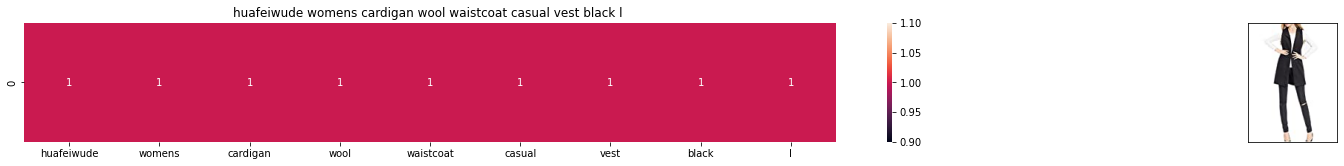

ASIN : B01MT96PXZ
Brand: Huafeiwude
Title: huafeiwude womens cardigan wool waistcoat casual vest black l 
Euclidean similarity with the query image : 0.0


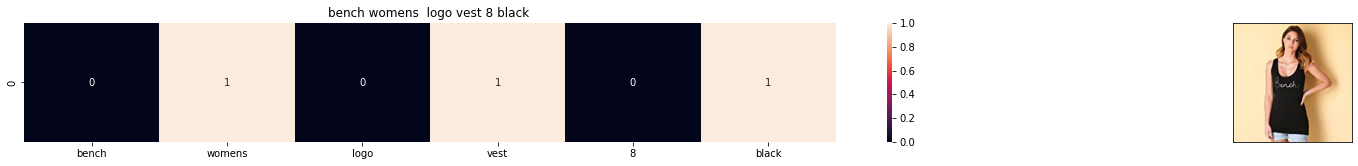

ASIN : B01MXMPTAD
Brand: Bench
Title: bench womens  logo vest 8 black 
Euclidean similarity with the query image : 2.6457513110645907


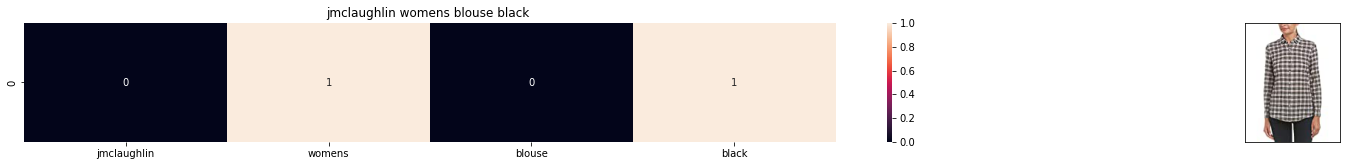

ASIN : B074KN55WS
Brand: J. McLaughlin
Title: jmclaughlin womens blouse black 
Euclidean similarity with the query image : 2.8284271247461903


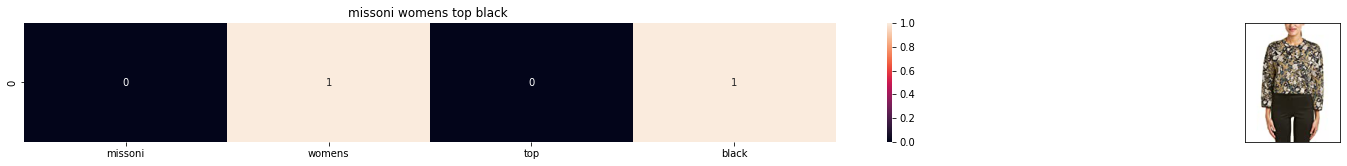

ASIN : B074TSFJHM
Brand: M Missoni
Title: missoni womens top black 
Euclidean similarity with the query image : 2.8284271247461903


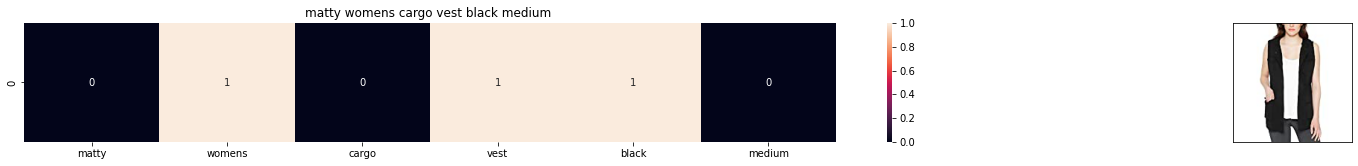

ASIN : B01LXQ055O
Brand: Matty M
Title: matty womens cargo vest black medium 
Euclidean similarity with the query image : 2.8284271247461903


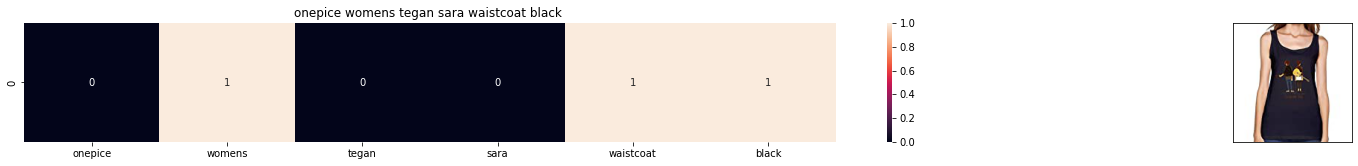

ASIN : B01EF0WPFI
Brand: ONEPICE
Title: onepice womens tegan sara waistcoat black 
Euclidean similarity with the query image : 2.8284271247461903


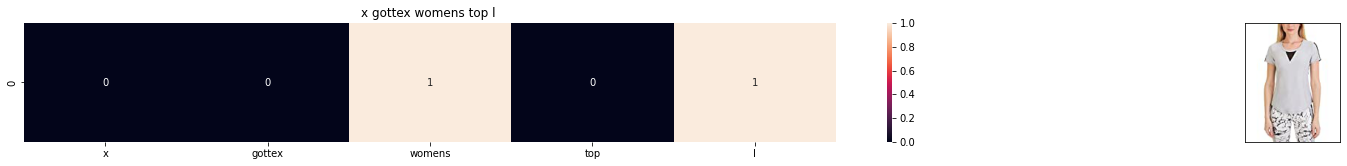

ASIN : B073M78XLP
Brand: X by Gottex
Title: x gottex womens top l 
Euclidean similarity with the query image : 3.0


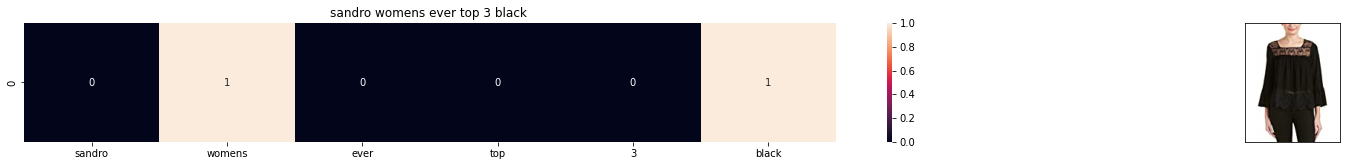

ASIN : B06XKX3BZL
Brand: Sandro
Title: sandro womens ever top 3 black 
Euclidean similarity with the query image : 3.0


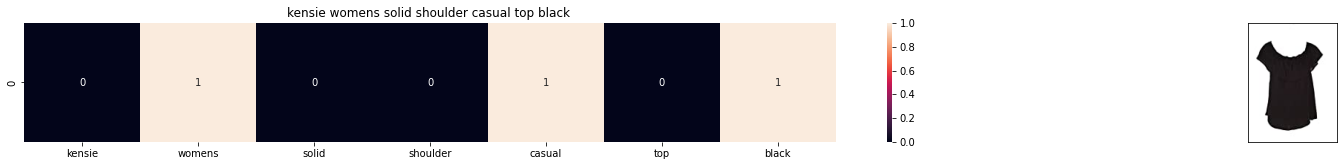

ASIN : B072HLFGT5
Brand: kensie
Title: kensie womens solid shoulder casual top black 
Euclidean similarity with the query image : 3.0


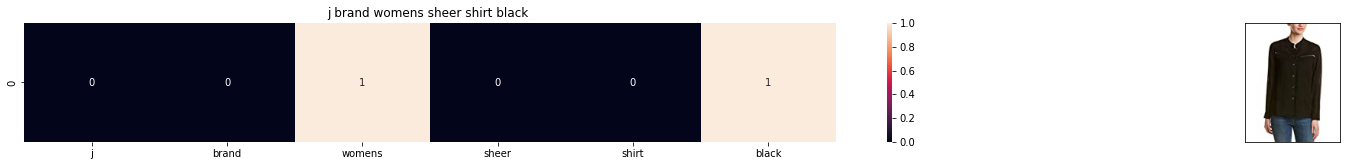

ASIN : B013L1V8PK
Brand: J Brand Jeans
Title: j brand womens sheer shirt black 
Euclidean similarity with the query image : 3.0


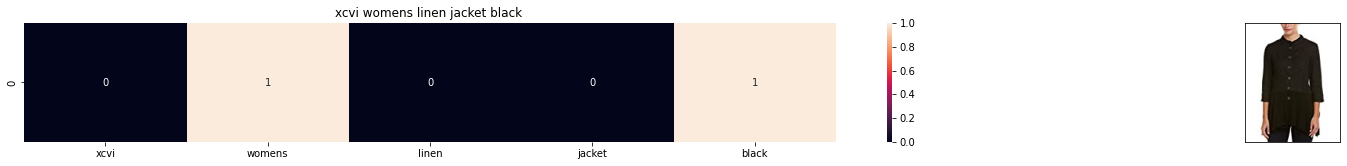

ASIN : B01M31Q4Z0
Brand: XCVI
Title: xcvi womens linen jacket black 
Euclidean similarity with the query image : 3.0


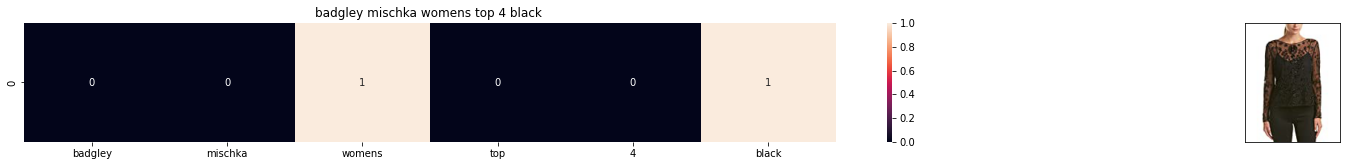

ASIN : B074TWLMJ8
Brand: Badgley Mischka
Title: badgley mischka womens top 4 black 
Euclidean similarity with the query image : 3.0


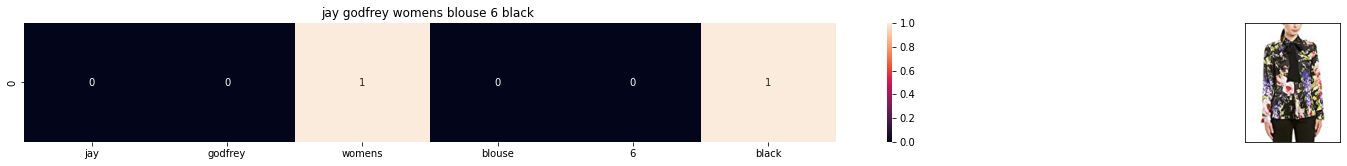

ASIN : B075B1NXKV
Brand: Jay Godfrey
Title: jay godfrey womens blouse 6 black 
Euclidean similarity with the query image : 3.0


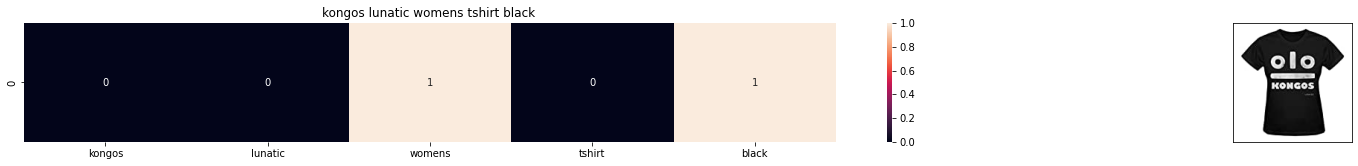

ASIN : B01IXZLJIA
Brand: Moonflow
Title: kongos lunatic womens tshirt black 
Euclidean similarity with the query image : 3.0


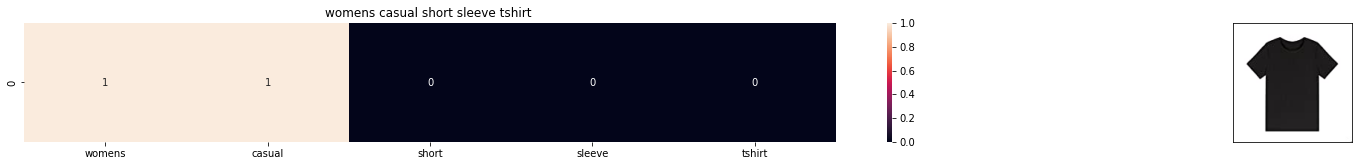

ASIN : B074T9KG9Q
Brand: Rain
Title: womens casual short sleeve tshirt 
Euclidean similarity with the query image : 3.0


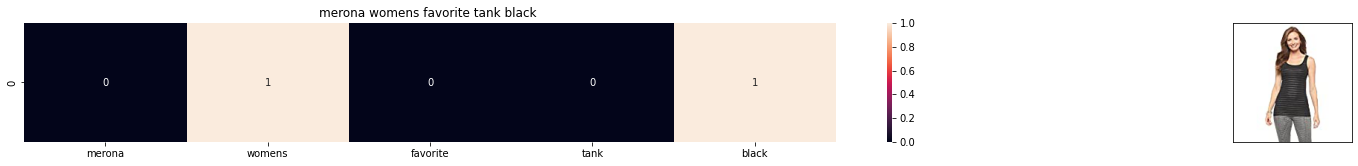

ASIN : B01KBGZE4Y
Brand: Merona
Title: merona womens favorite tank black 
Euclidean similarity with the query image : 3.0


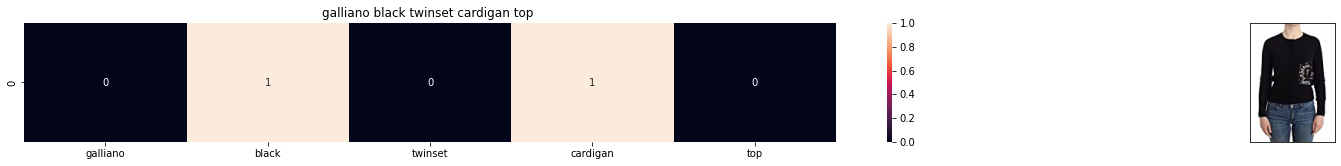

ASIN : B074G57HQJ
Brand: Galliano
Title: galliano black twinset cardigan top 
Euclidean similarity with the query image : 3.0


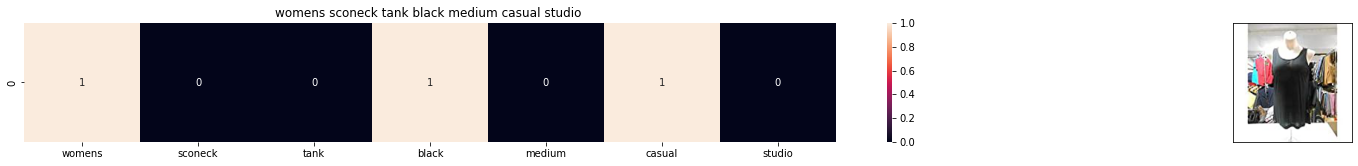

ASIN : B06ZZCKDQW
Brand: Casual Studio
Title: womens sconeck tank black medium casual studio 
Euclidean similarity with the query image : 3.0


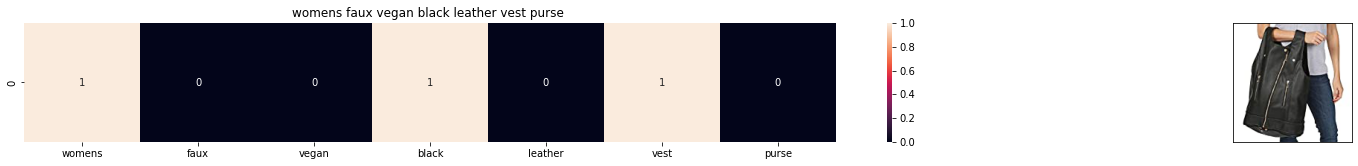

ASIN : B01M34NPAM
Brand: WHAT ON EARTH
Title: womens faux vegan black leather vest purse 
Euclidean similarity with the query image : 3.0


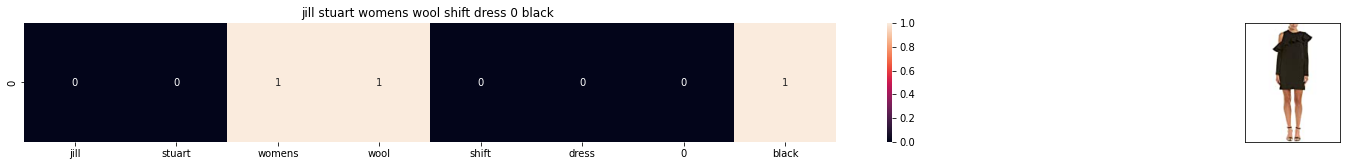

ASIN : B07591PX36
Brand: Jill Stuart
Title: jill stuart womens wool shift dress 0 black 
Euclidean similarity with the query image : 3.0


In [76]:
plotly.offline.init_notebook_mode(connected=True)
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    
    # pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    # data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand:', data['brand'].loc[df_indices[i]])
        print('Title:', data['title'].loc[df_indices[i]])
        print('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

# calling the bag-of-words model for a product to get similar products.
bag_of_words_model(12566, 20)
# In the output heat map each value represents the count value 
# of the label word, the color represents the intersection 
# with inputs title.

## TF-IDF based product similarity

In [ ]:
# TF-IDF returns a sparse matrix
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

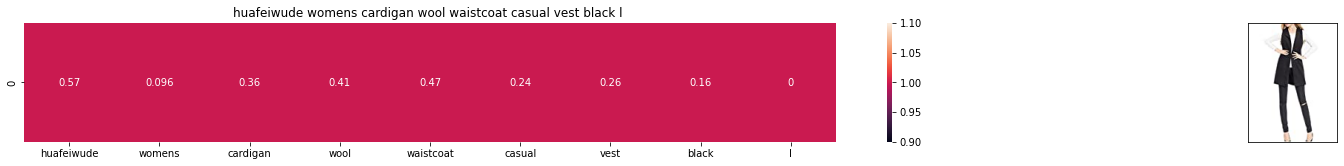

ASIN : B01MT96PXZ
BRAND : Huafeiwude
Eucliden distance from the given image : 0.0


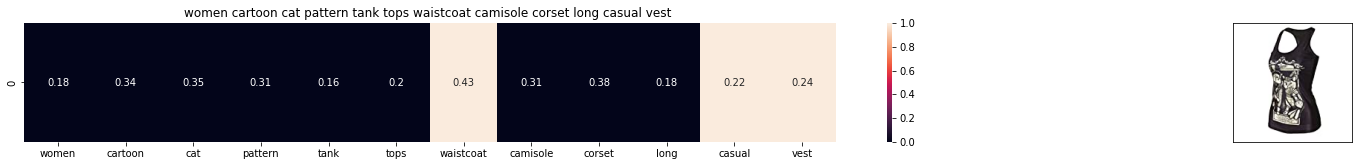

ASIN : B011R13YBM
BRAND : Huayang
Eucliden distance from the given image : 1.1722779213868202


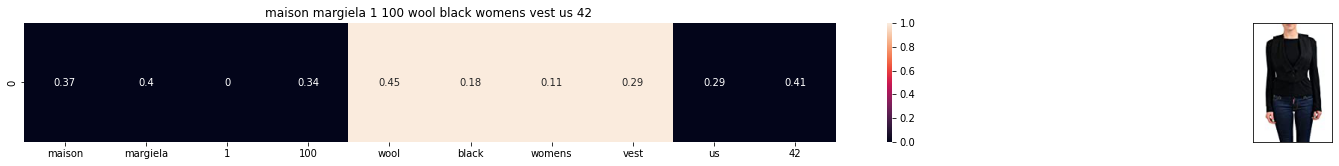

ASIN : B01N58BIEH
BRAND : Maison Margiela
Eucliden distance from the given image : 1.1859602292161415


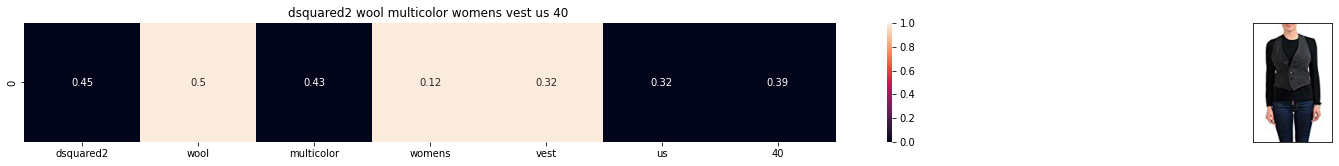

ASIN : B01N2MU4DR
BRAND : DSQUARED2
Eucliden distance from the given image : 1.188600377321188


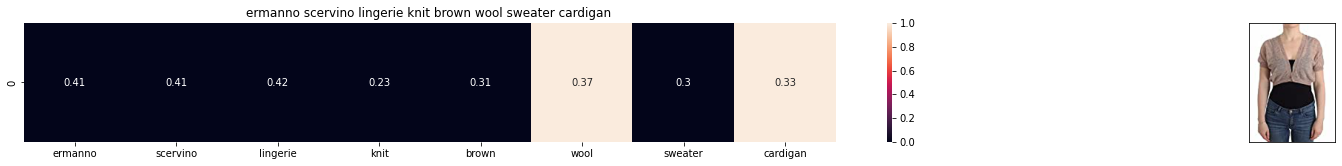

ASIN : B074G59T11
BRAND : ERMANNO SCERVINO
Eucliden distance from the given image : 1.206359485845001


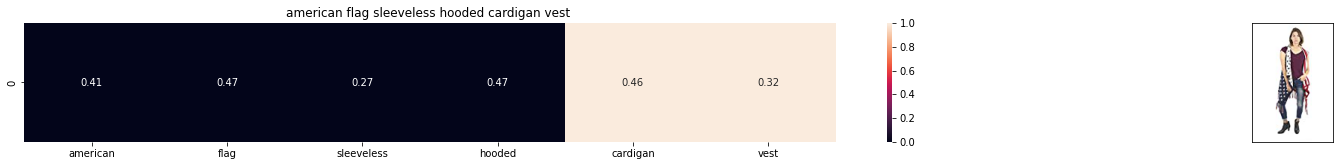

ASIN : B01MF523XO
BRAND : A&O International
Eucliden distance from the given image : 1.225015799943407


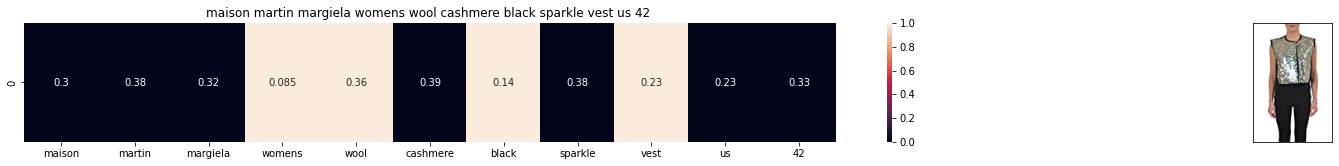

ASIN : B0175G7C20
BRAND : Maison Martin Margiela
Eucliden distance from the given image : 1.2351958567475707


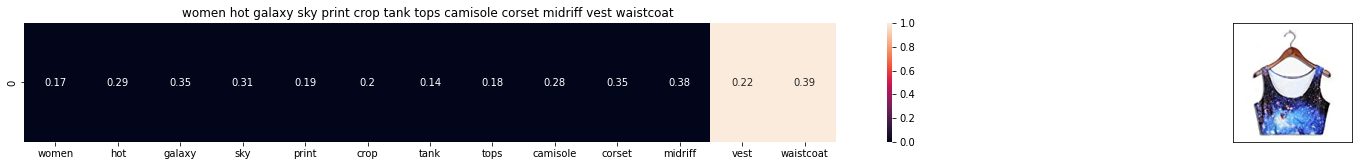

ASIN : B011R13I5Y
BRAND : Huayang
Eucliden distance from the given image : 1.236015538222882


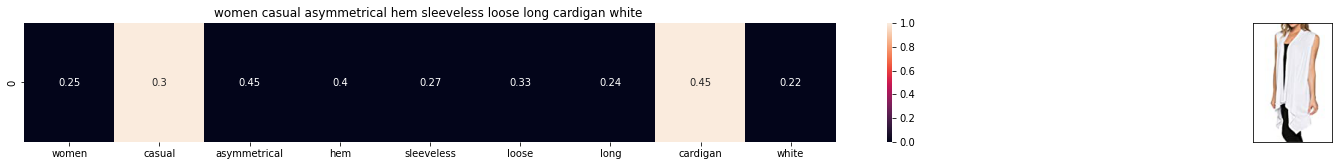

ASIN : B019V3MIP6
BRAND : KingField
Eucliden distance from the given image : 1.2364678792669093


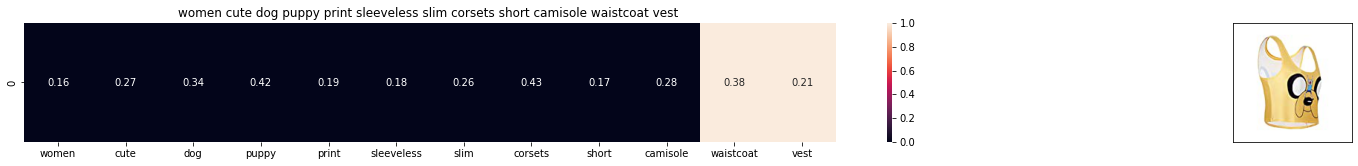

ASIN : B011R13T2Q
BRAND : Huayang
Eucliden distance from the given image : 1.2395445383327484


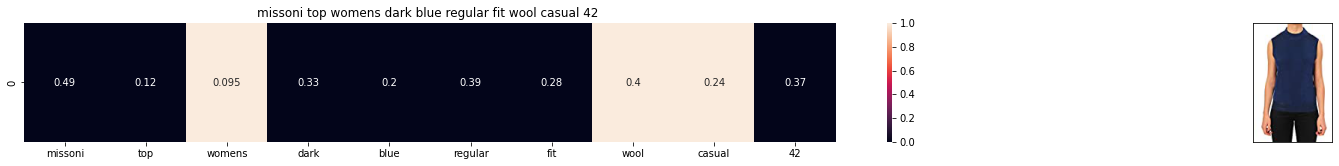

ASIN : B06XY144C5
BRAND : Missoni
Eucliden distance from the given image : 1.2415915469686623


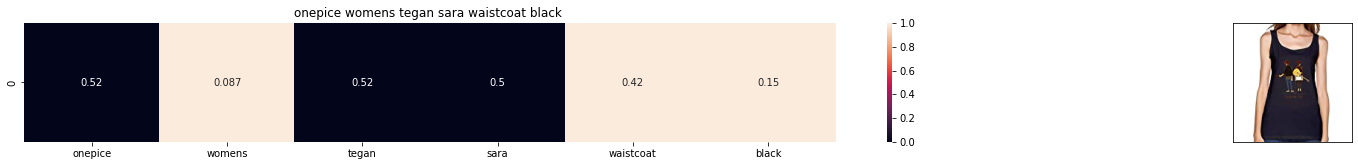

ASIN : B01EF0WPFI
BRAND : ONEPICE
Eucliden distance from the given image : 1.2416544379264938


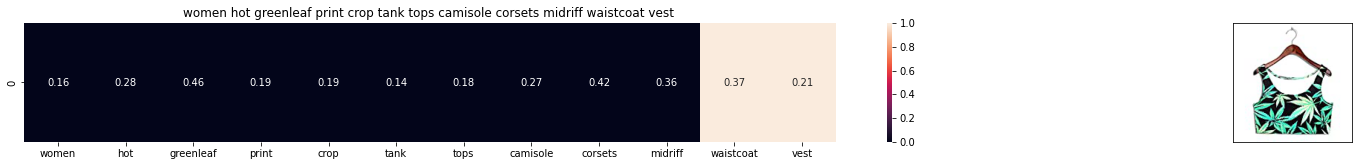

ASIN : B011R13OVW
BRAND : Huayang
Eucliden distance from the given image : 1.2428237398407325


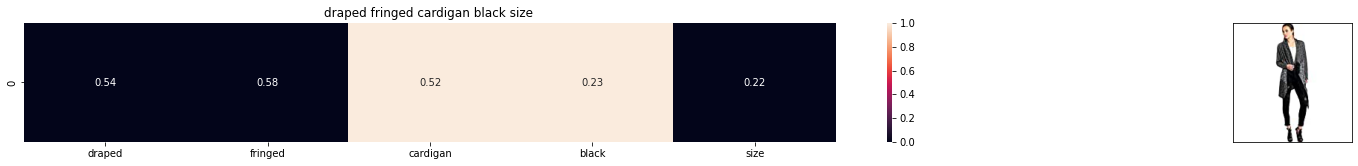

ASIN : B01CB33866
BRAND : Flying Tomato
Eucliden distance from the given image : 1.2439474778333672


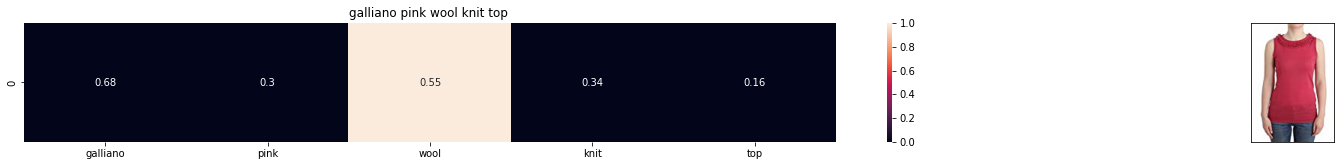

ASIN : B074G4V6NJ
BRAND : Galliano
Eucliden distance from the given image : 1.246074624114252


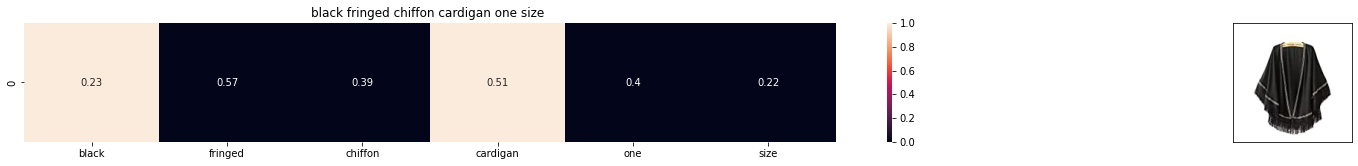

ASIN : B010AMAMLY
BRAND : HP-LEISURE
Eucliden distance from the given image : 1.2463648318197242


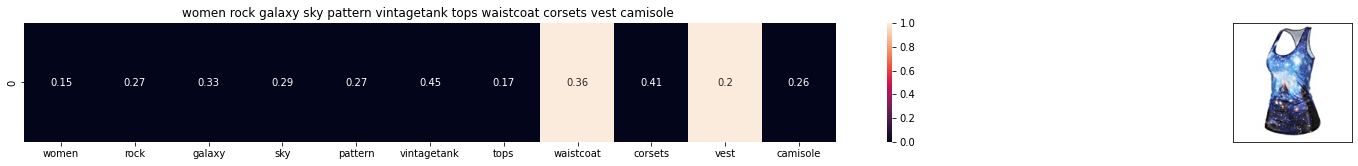

ASIN : B011R13M1O
BRAND : Huayang
Eucliden distance from the given image : 1.2479129830677684


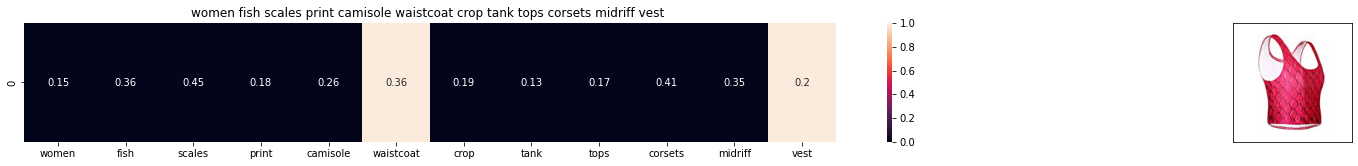

ASIN : B011R13BDS
BRAND : Huayang
Eucliden distance from the given image : 1.247961302381963


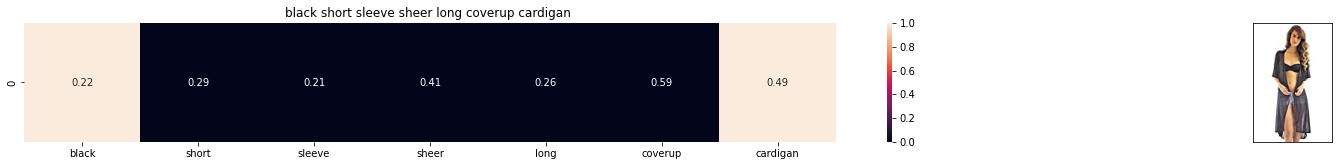

ASIN : B01GIP26MA
BRAND : Luxury Divas
Eucliden distance from the given image : 1.2521865818430968


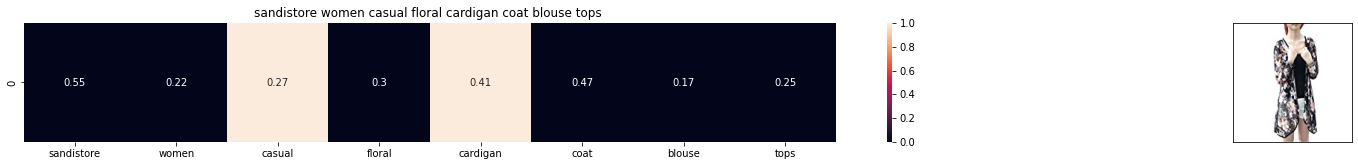

ASIN : B01AVX8IOU
BRAND : Sandistore
Eucliden distance from the given image : 1.2527438390346828


In [ ]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print('Eucliden simi from the given image :', pdists[i])
        print('='*125)
tfidf_model(12566, 20)
# in the output heat map, each value represents the tfidf values of the label word, the color represents the intersection with inputs title

## IDF based product similarity

In [ ]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])
# idf_title_features.shape = # of data_points * # of words_in_corpus

In [ ]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [ ]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val

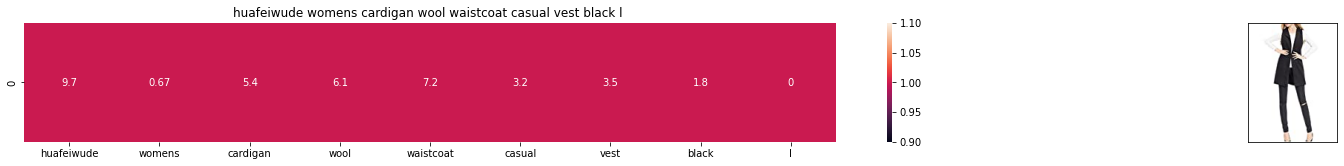

ASIN : B01MT96PXZ
Brand : Huafeiwude
euclidean distance from the given image : 0.0


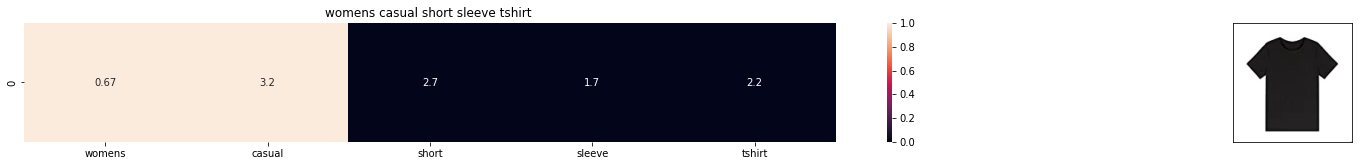

ASIN : B074T9KG9Q
Brand : Rain
euclidean distance from the given image : 15.615323652053057


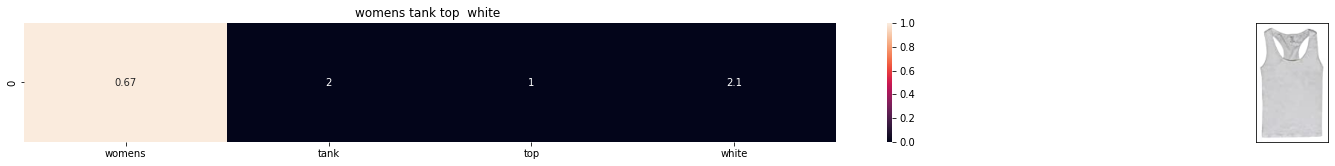

ASIN : B00JPOZ9GM
Brand : Sofra
euclidean distance from the given image : 15.744264266781588


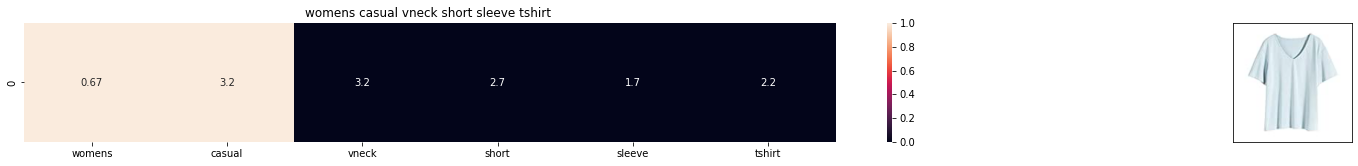

ASIN : B074V45DCX
Brand : Rain
euclidean distance from the given image : 15.945600577587768


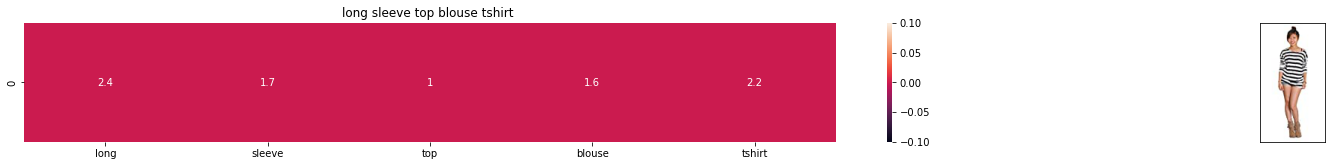

ASIN : B00KF2N5PU
Brand : Vietsbay
euclidean distance from the given image : 16.01194197210101


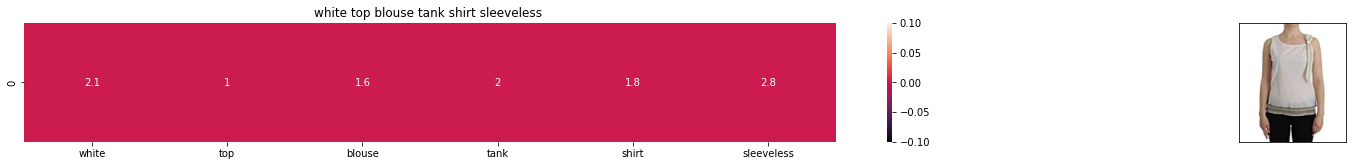

ASIN : B074G5G5RK
Brand : ERMANNO SCERVINO
euclidean distance from the given image : 16.193269507398313


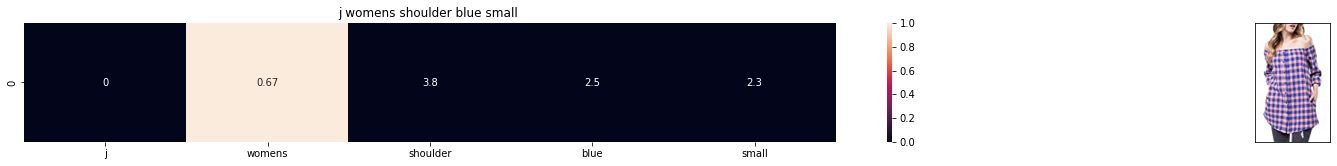

ASIN : B07583CQFT
Brand : Very J
euclidean distance from the given image : 16.2686385443419


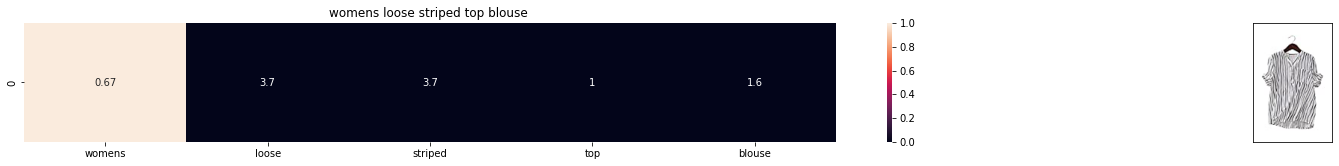

ASIN : B00ZZMYBRG
Brand : HP-LEISURE
euclidean distance from the given image : 16.426585216722245


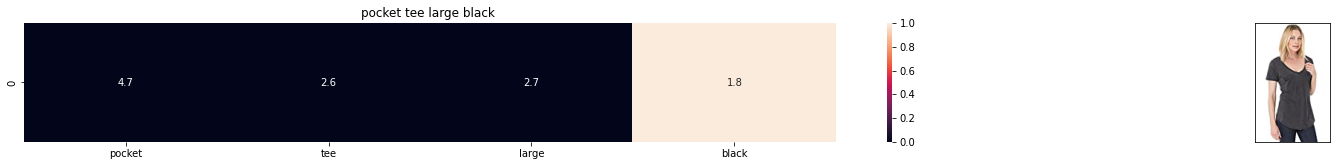

ASIN : B017I2YWUQ
Brand : Z SUPPLY
euclidean distance from the given image : 16.486585572396056


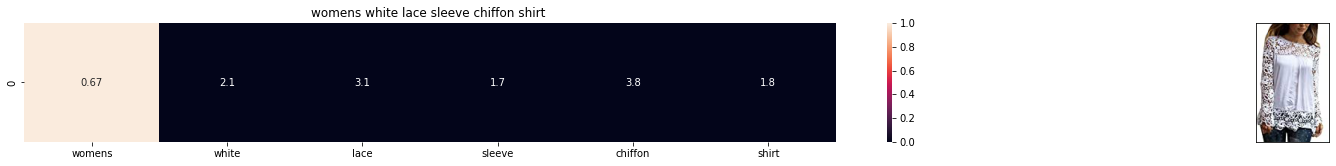

ASIN : B073JWSM1V
Brand : Fuming
euclidean distance from the given image : 16.5367556138437


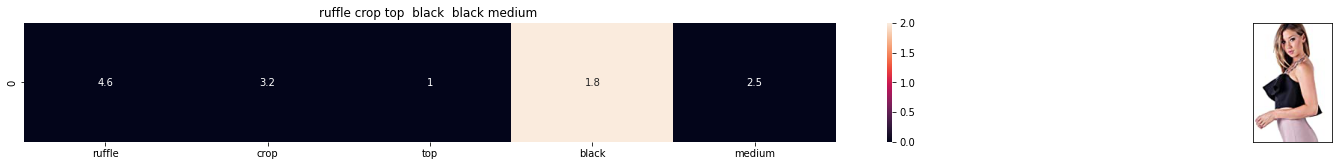

ASIN : B01HT0OL3K
Brand : Lushfox
euclidean distance from the given image : 16.564678175488137


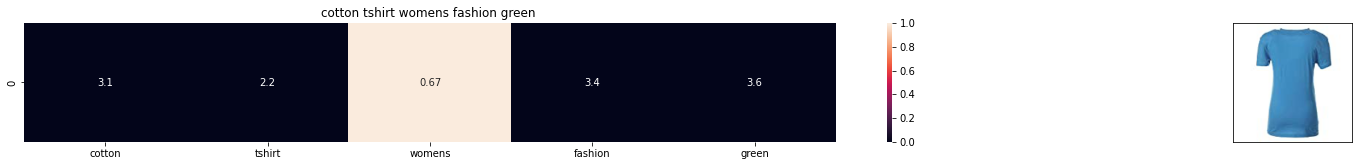

ASIN : B073GJGVBN
Brand : Ivan Levi
euclidean distance from the given image : 16.6575495972295


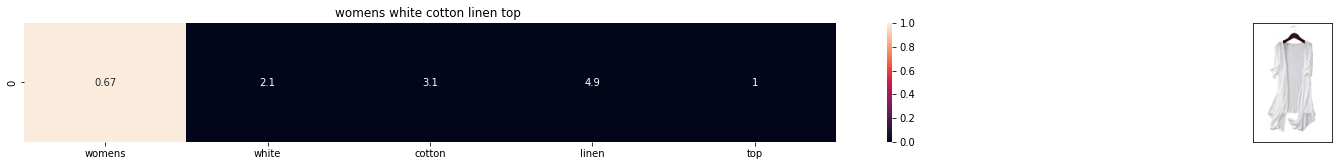

ASIN : B00ZZPR4Y0
Brand : HP-LEISURE
euclidean distance from the given image : 16.65800447522085


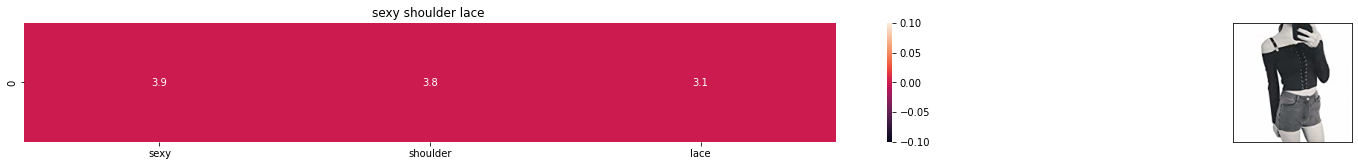

ASIN : B01JVWUB3S
Brand : bylexie
euclidean distance from the given image : 16.67188980155837


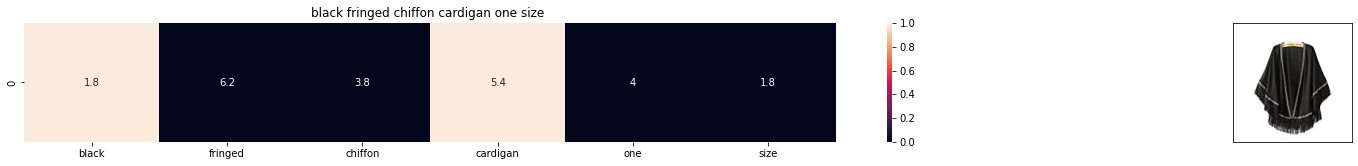

ASIN : B010AMAMLY
Brand : HP-LEISURE
euclidean distance from the given image : 16.68256175427422


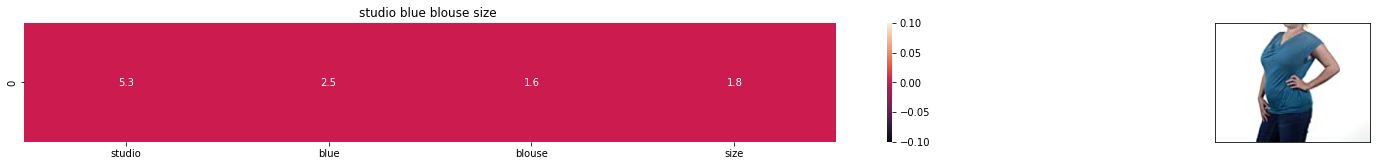

ASIN : B016P80OKQ
Brand : Studio M
euclidean distance from the given image : 16.692865428465016


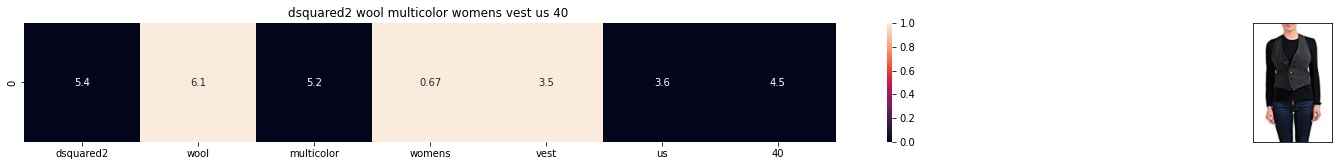

ASIN : B01N2MU4DR
Brand : DSQUARED2
euclidean distance from the given image : 16.69820390236253


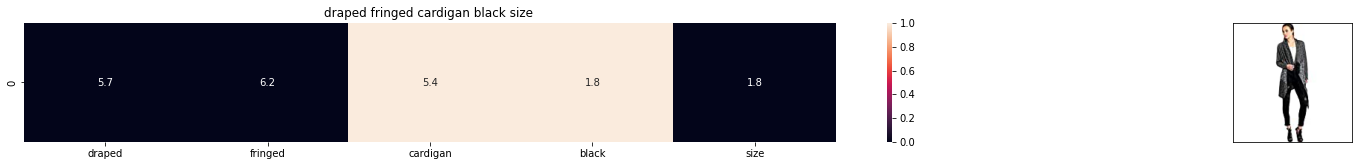

ASIN : B01CB33866
Brand : Flying Tomato
euclidean distance from the given image : 16.724506545515847


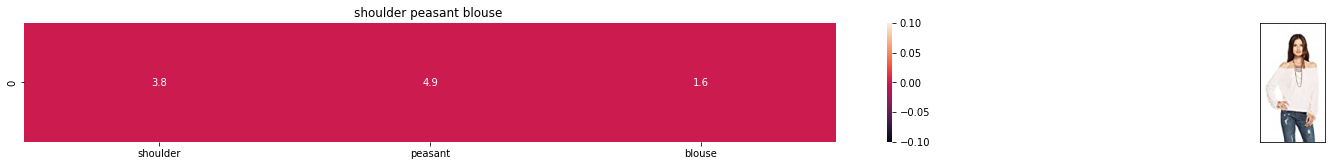

ASIN : B01E1QD5PK
Brand : CHASER
euclidean distance from the given image : 16.727657052754815


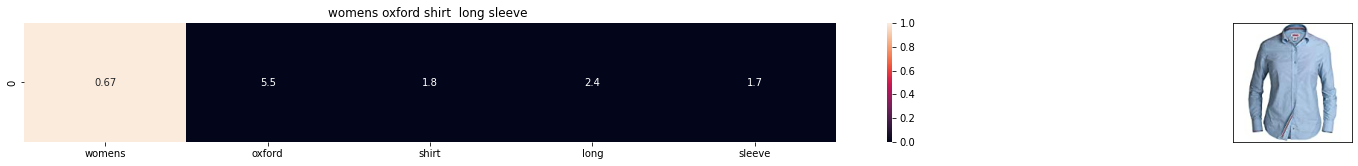

ASIN : B01577JZOC
Brand : Boast
euclidean distance from the given image : 16.750308337761325


In [ ]:
def idf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    
    # pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    # data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from the given image :', pdists[i])
        print('='*125)

        
        
idf_model(12566,20)
# in the output heat map, each value represents the idf values of the label word, the color represents the intersection with inputs title

## Text Semantics based product similarity

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

with open('/content/word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [ ]:
# Utility functions

def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # divide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [ ]:
# vocab = stores all the words that are there in google w2v model

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

## Average Word2Vec product similarity.

In [ ]:
doc_id = 0
w2v_title = []

# for every title we build a avg vector representation
for i in data['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title = np.array(w2v_title)

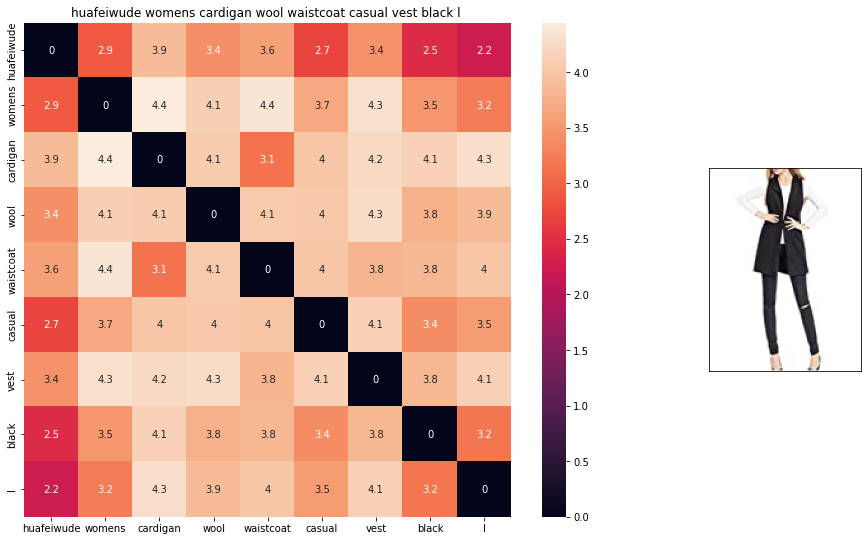

ASIN : B01MT96PXZ
BRAND : Huafeiwude
euclidean distance from given input image : 0.0


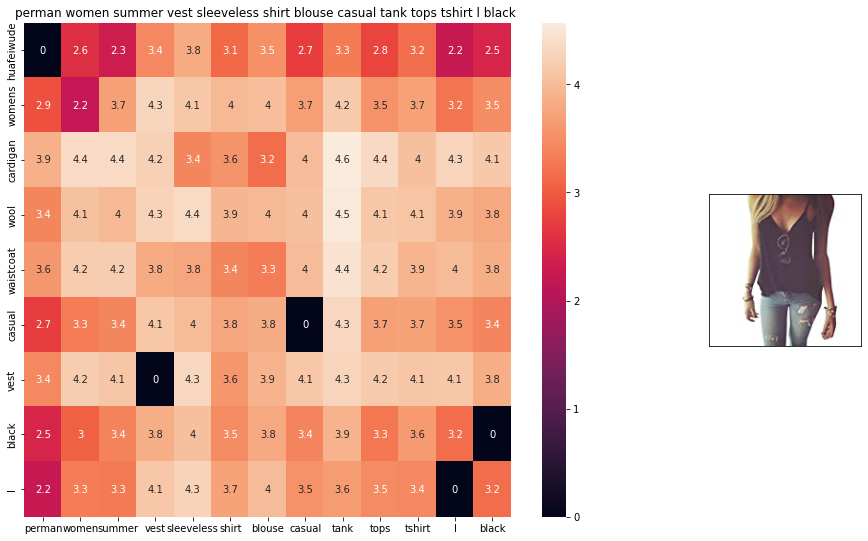

ASIN : B01F852VDK
BRAND : Perman
euclidean distance from given input image : 0.8539957


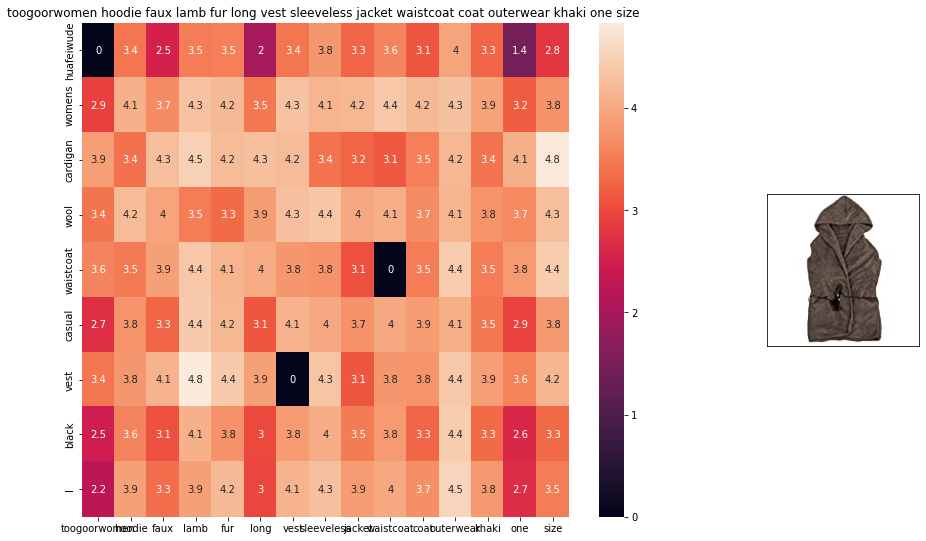

ASIN : B00R10GCHC
BRAND : TOOGOO(R)
euclidean distance from given input image : 0.8619427


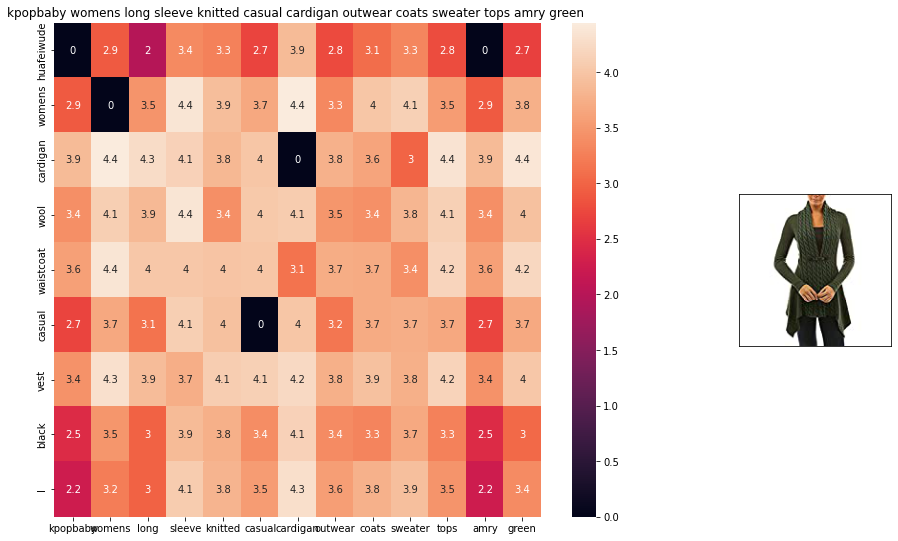

ASIN : B074LD7G7K
BRAND : KpopBaby
euclidean distance from given input image : 0.87473196


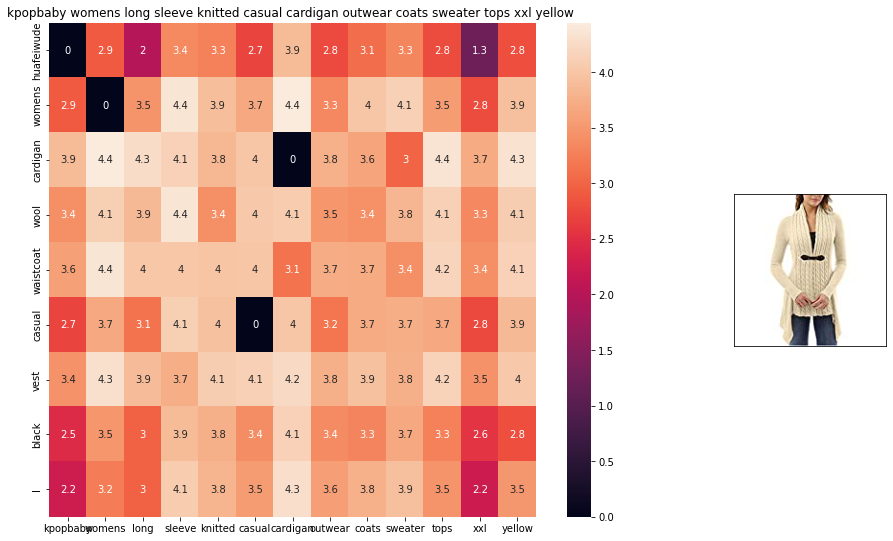

ASIN : B074LCPJJZ
BRAND : KpopBaby
euclidean distance from given input image : 0.88326466


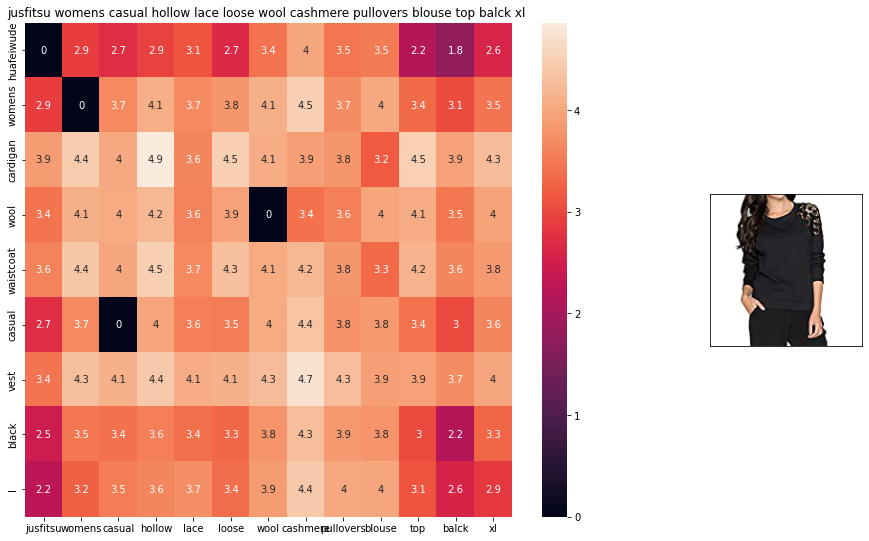

ASIN : B01N96GX38
BRAND : Jusfitsu
euclidean distance from given input image : 0.8868851


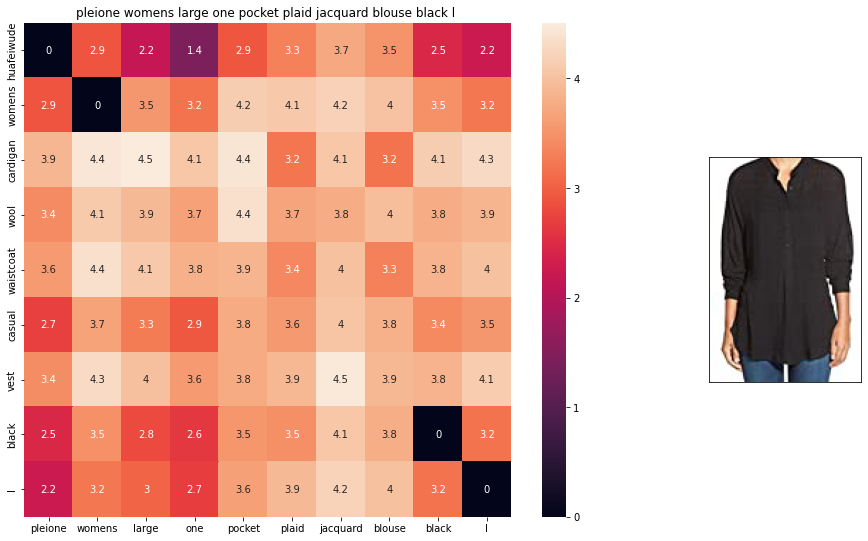

ASIN : B06XGQ9CSM
BRAND : Pleione
euclidean distance from given input image : 0.8881678


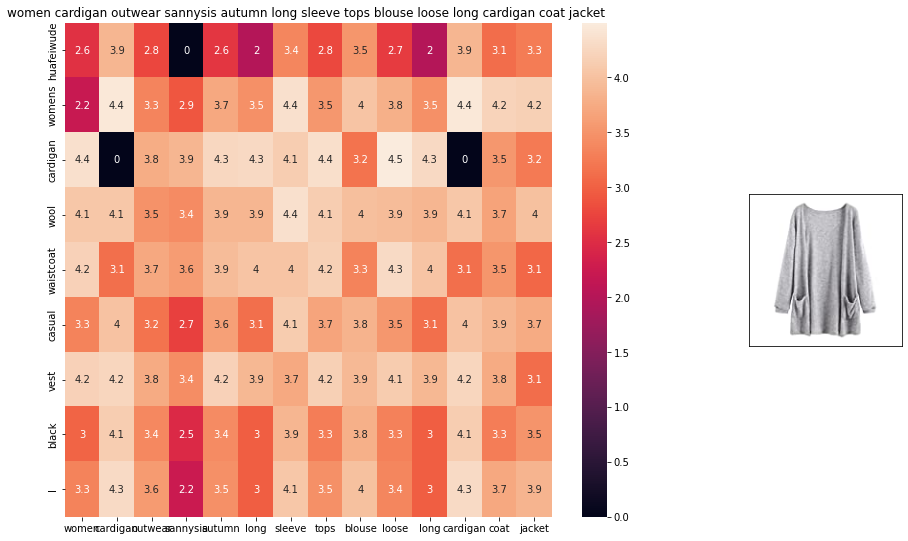

ASIN : B07473KFK1
BRAND : Sannysis
euclidean distance from given input image : 0.89271647


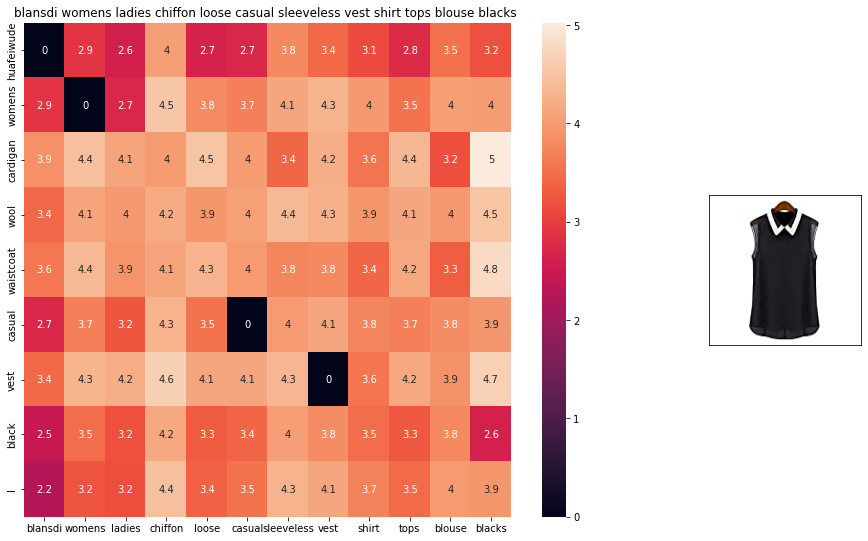

ASIN : B01B3Y99XA
BRAND : Blansdi
euclidean distance from given input image : 0.8936688


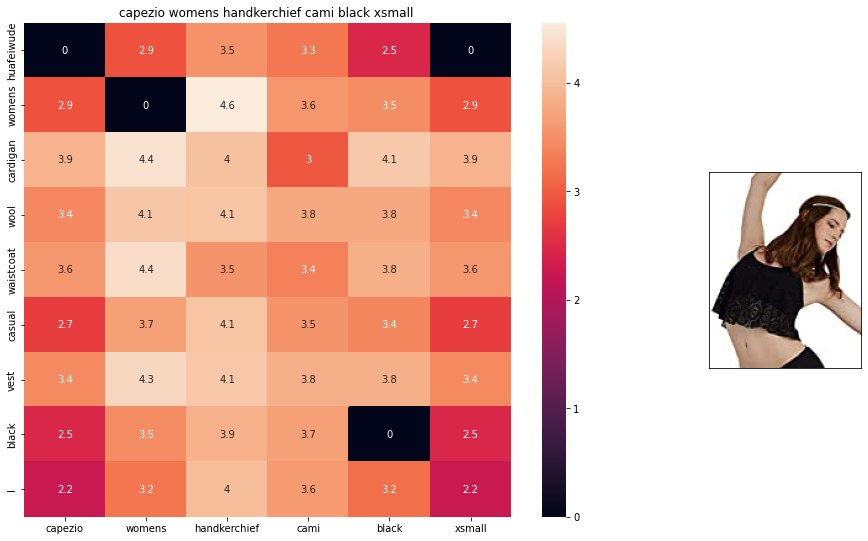

ASIN : B00ZIY47WA
BRAND : Capezio
euclidean distance from given input image : 0.89525115


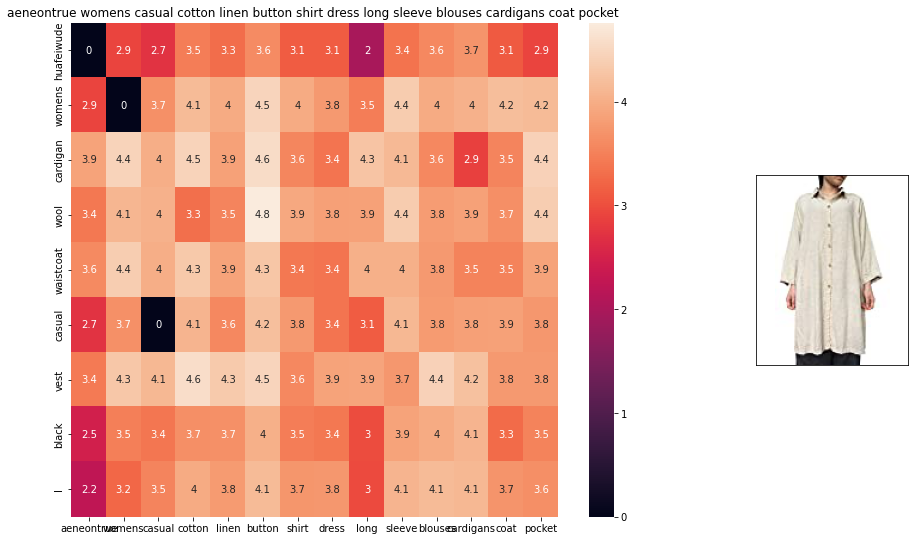

ASIN : B074V1K5QJ
BRAND : Aeneontrue
euclidean distance from given input image : 0.9028107


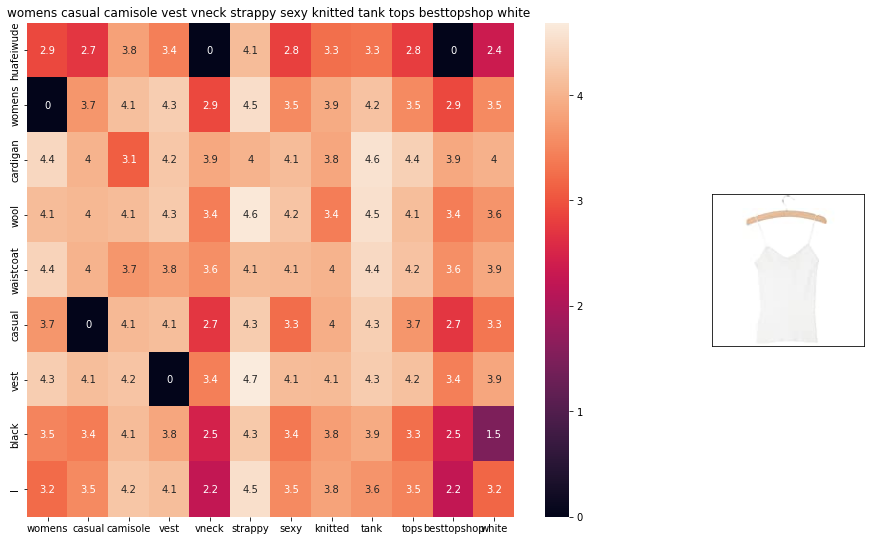

ASIN : B071XV9DKH
BRAND : Best Music Posters
euclidean distance from given input image : 0.9065367


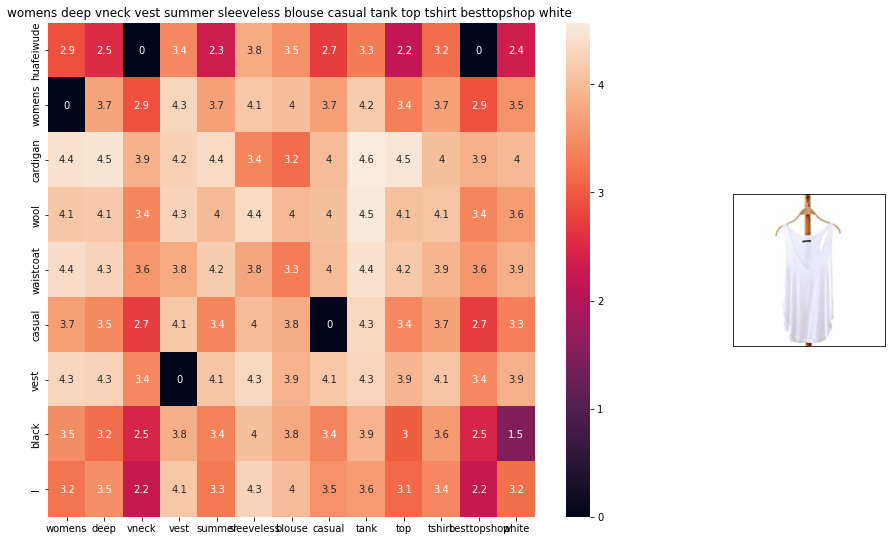

ASIN : B071Y6W6D8
BRAND : Best Music Posters
euclidean distance from given input image : 0.9093141


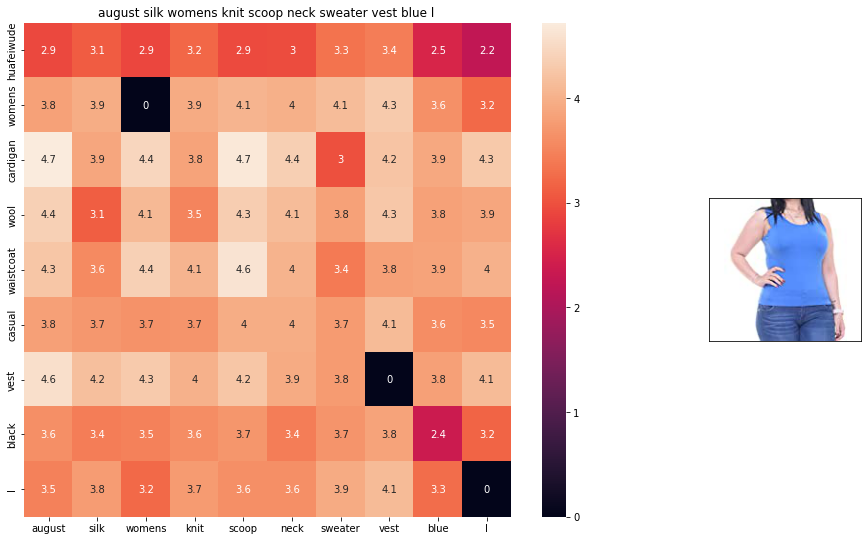

ASIN : B06X6N47HY
BRAND : August Silk
euclidean distance from given input image : 0.9097892


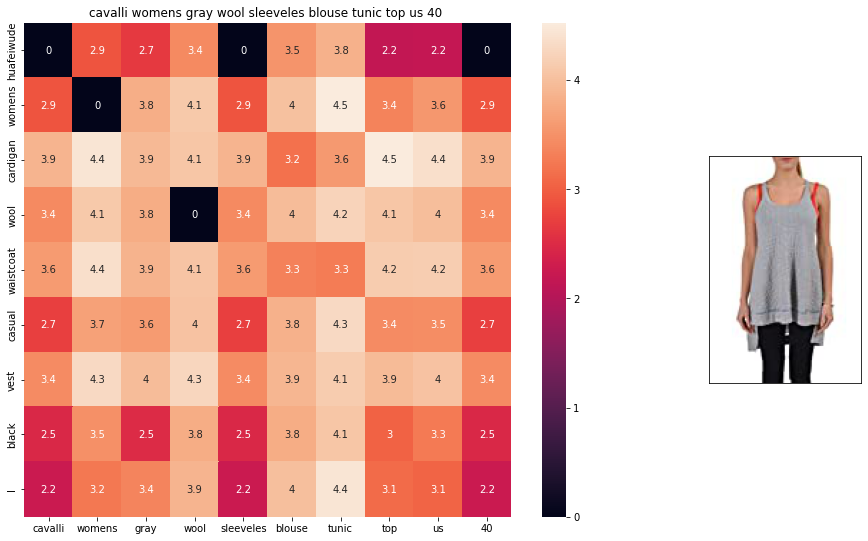

ASIN : B0175AT71K
BRAND : Just Cavalli
euclidean distance from given input image : 0.9117741


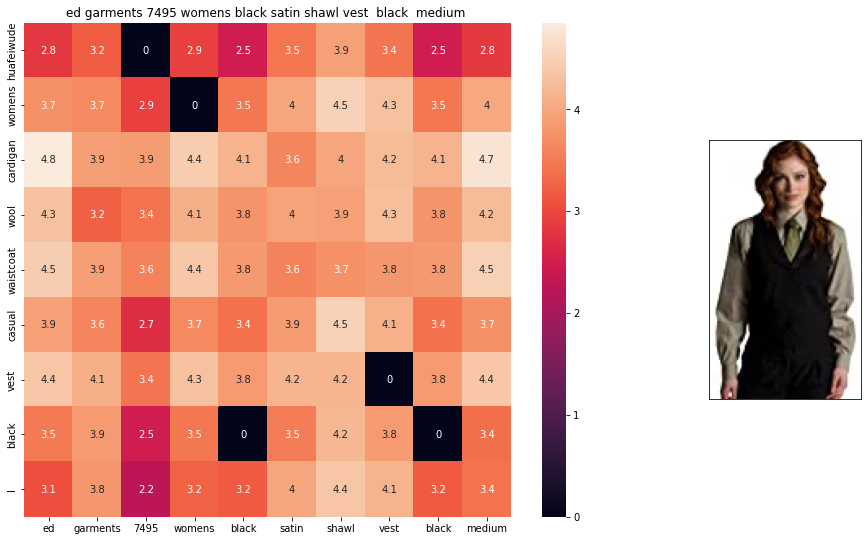

ASIN : B007X49OCG
BRAND : Edwards Garment
euclidean distance from given input image : 0.91356814


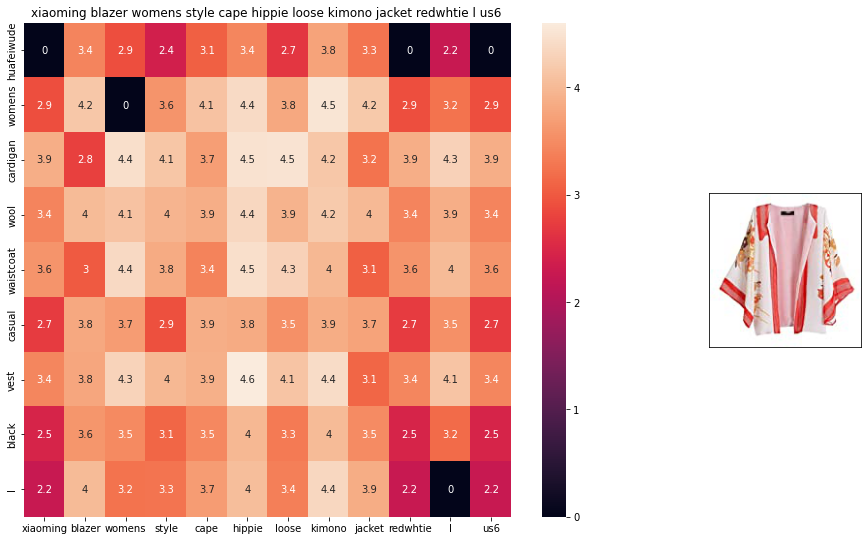

ASIN : B00WPK4T4G
BRAND : xiaoming
euclidean distance from given input image : 0.9149437


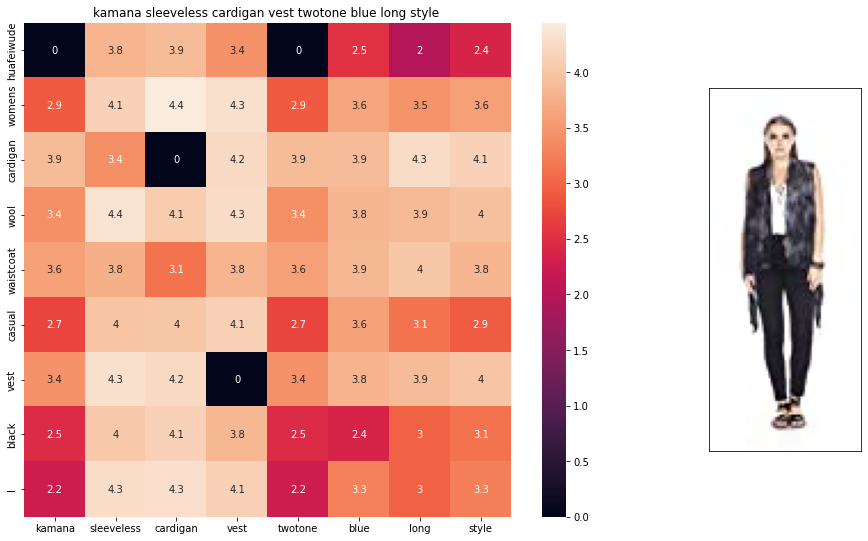

ASIN : B0751686K7
BRAND : Kamana
euclidean distance from given input image : 0.917094


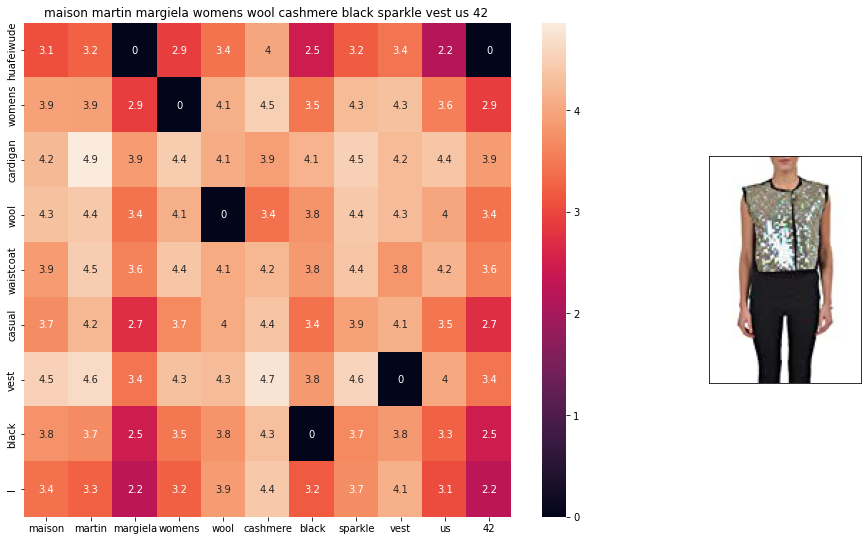

ASIN : B0175G7C20
BRAND : Maison Martin Margiela
euclidean distance from given input image : 0.9177549


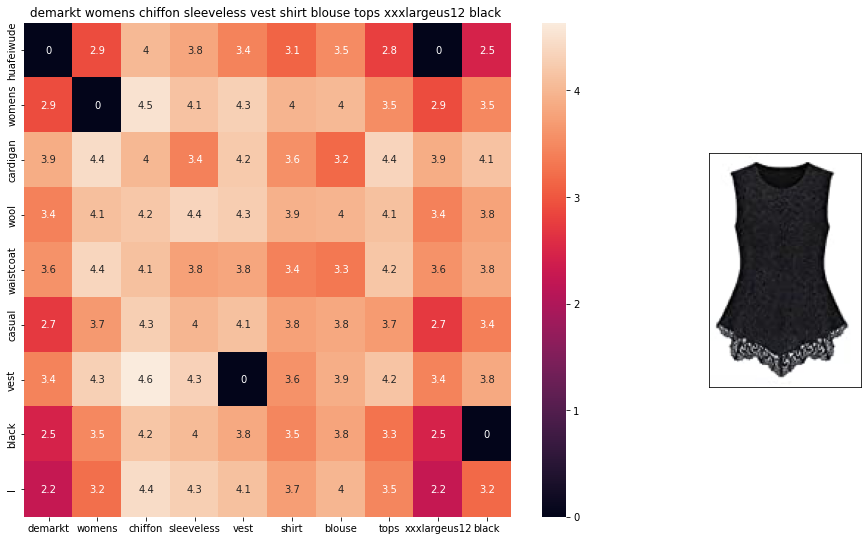

ASIN : B00JKCQZJE
BRAND : Demarkt
euclidean distance from given input image : 0.917883


In [ ]:
plotly.offline.init_notebook_mode(connected=True)
def avg_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from given input image :', pdists[i])
        print('='*125)

        
avg_w2v_model(12566, 20)
# in the heat map, each cell contains the euclidean distance between words i, j

##  IDF weighted Word2Vec for product similarity.

In [ ]:
doc_id = 0
w2v_title_weight = []

# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
    
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

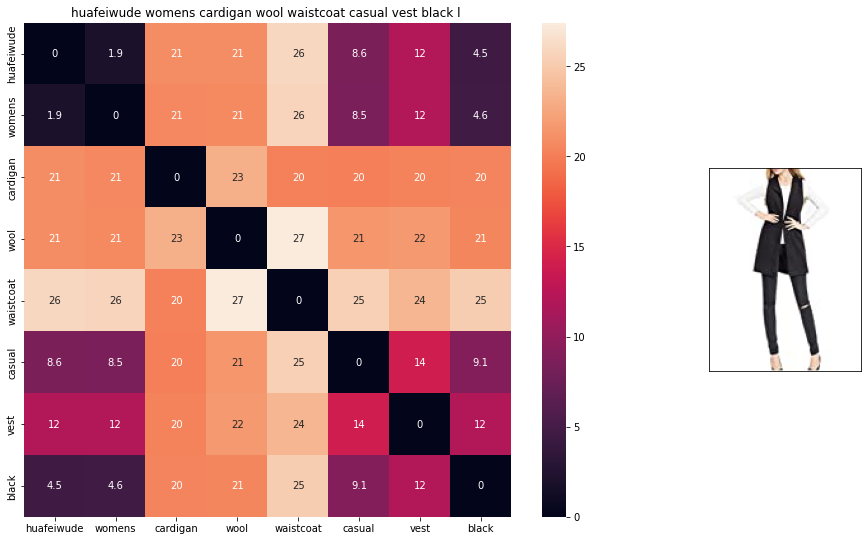

ASIN : B01MT96PXZ
Brand : Huafeiwude
euclidean distance from input : 0.0


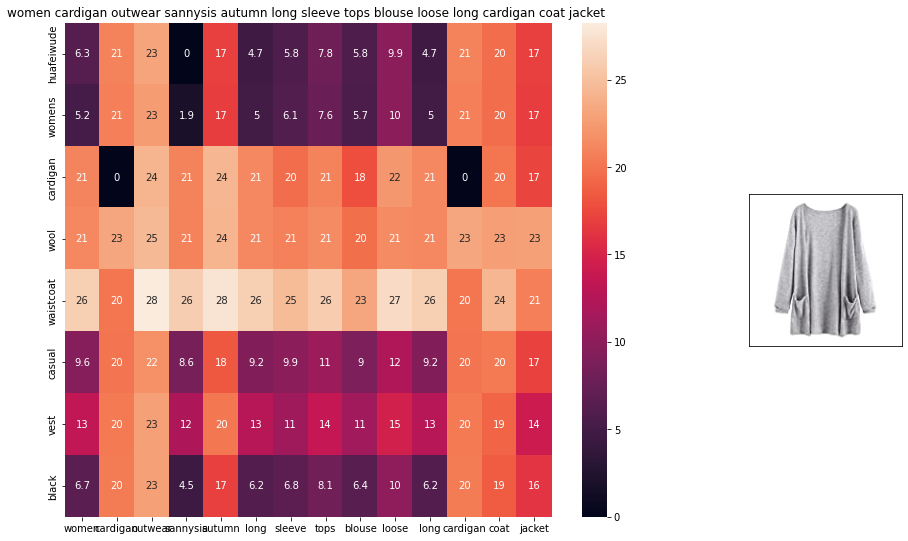

ASIN : B07473KFK1
Brand : Sannysis
euclidean distance from input : 3.7969613


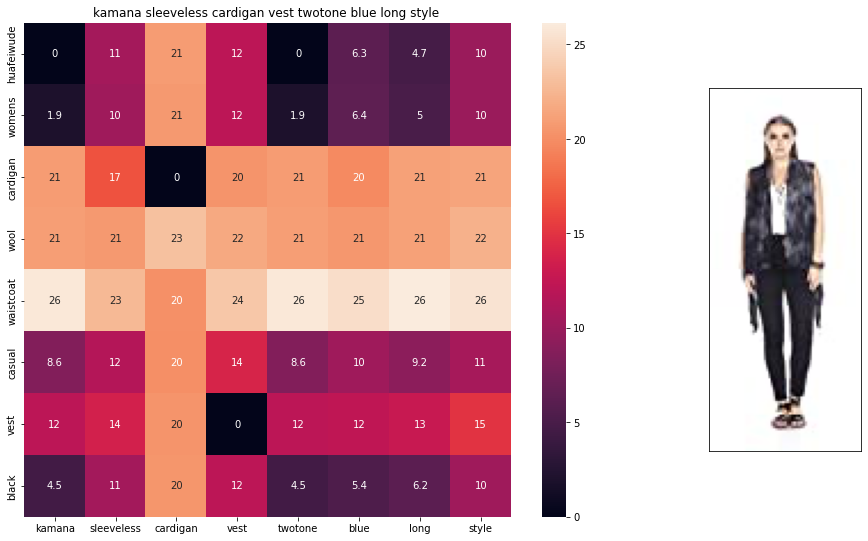

ASIN : B0751686K7
Brand : Kamana
euclidean distance from input : 3.9051597


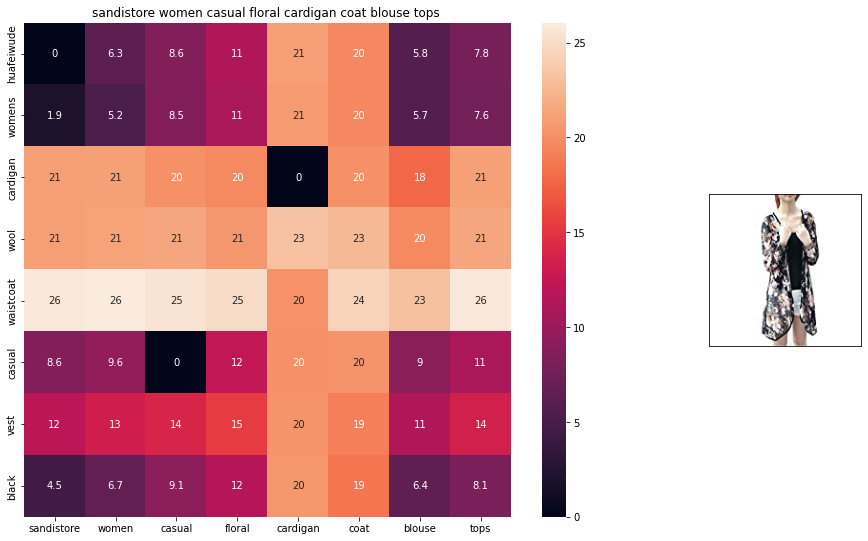

ASIN : B01AVX8IOU
Brand : Sandistore
euclidean distance from input : 3.9728305


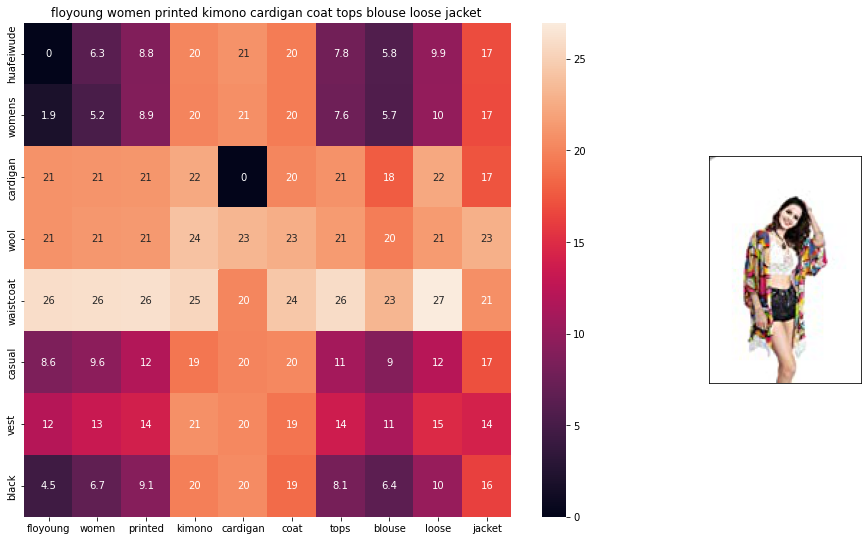

ASIN : B01D6EUG3W
Brand : FloYoung
euclidean distance from input : 3.9933598


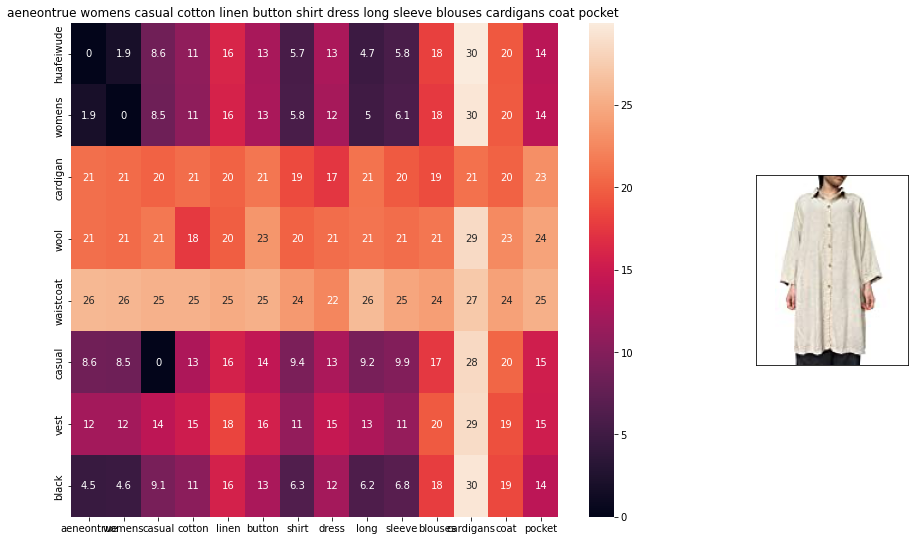

ASIN : B074V1K5QJ
Brand : Aeneontrue
euclidean distance from input : 4.0558114


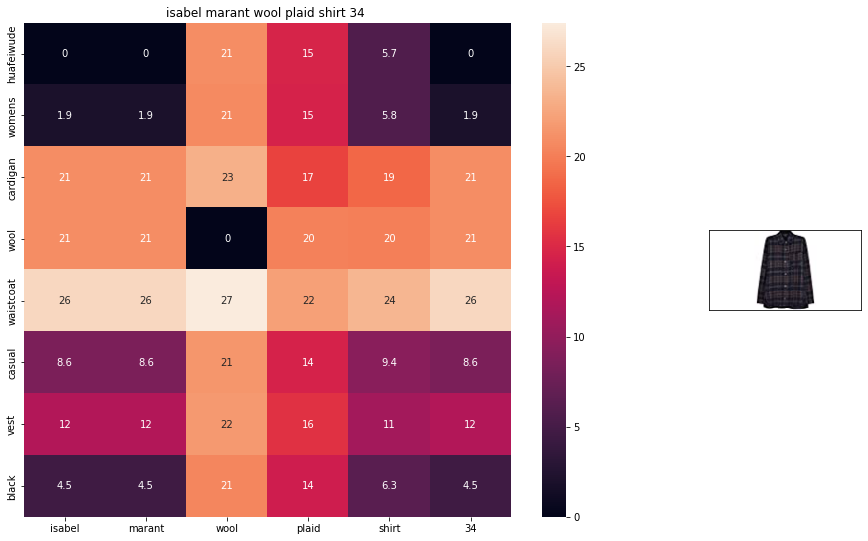

ASIN : B074NBDL2W
Brand : Isabel Marant
euclidean distance from input : 4.211965


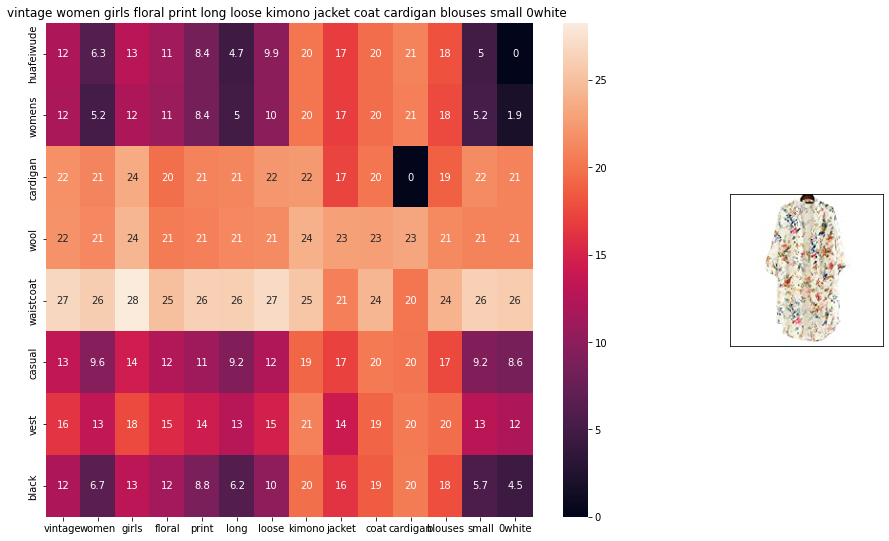

ASIN : B07375JCKD
Brand : ACEFAST INC
euclidean distance from input : 4.2146835


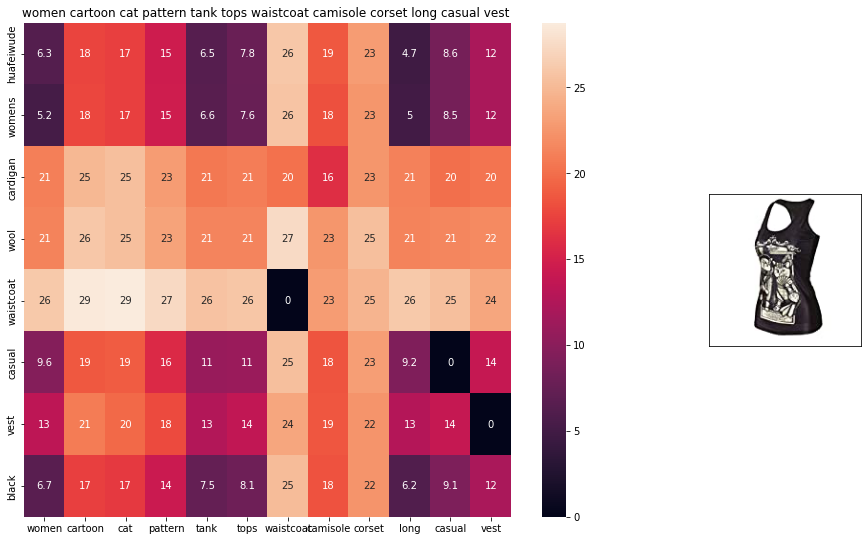

ASIN : B011R13YBM
Brand : Huayang
euclidean distance from input : 4.2270885


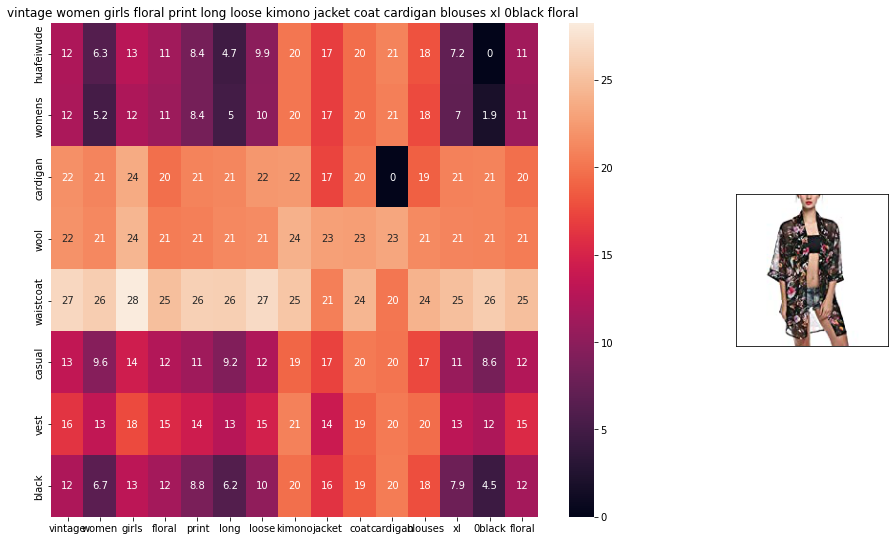

ASIN : B073PNYB2S
Brand : ACEFAST INC
euclidean distance from input : 4.2848


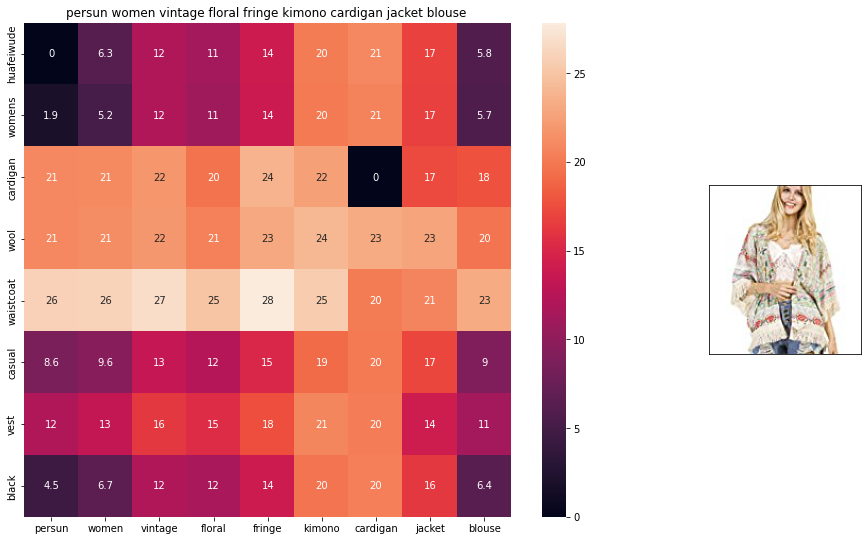

ASIN : B00Y26RSRQ
Brand : Persun
euclidean distance from input : 4.2976522


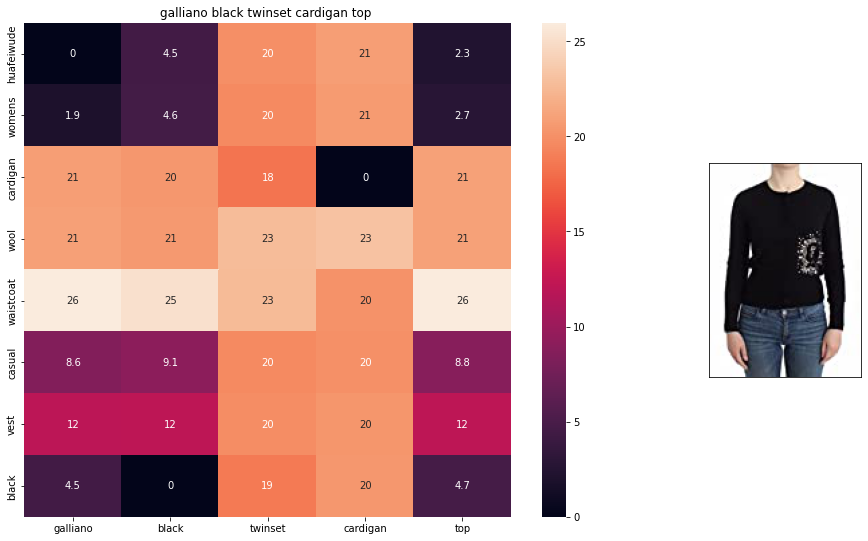

ASIN : B074G57HQJ
Brand : Galliano
euclidean distance from input : 4.3163776


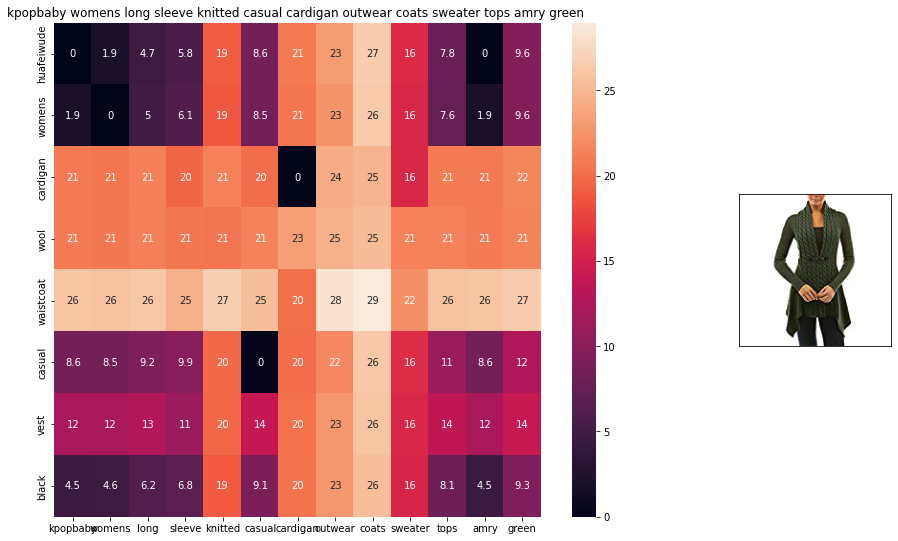

ASIN : B074LD7G7K
Brand : KpopBaby
euclidean distance from input : 4.35567


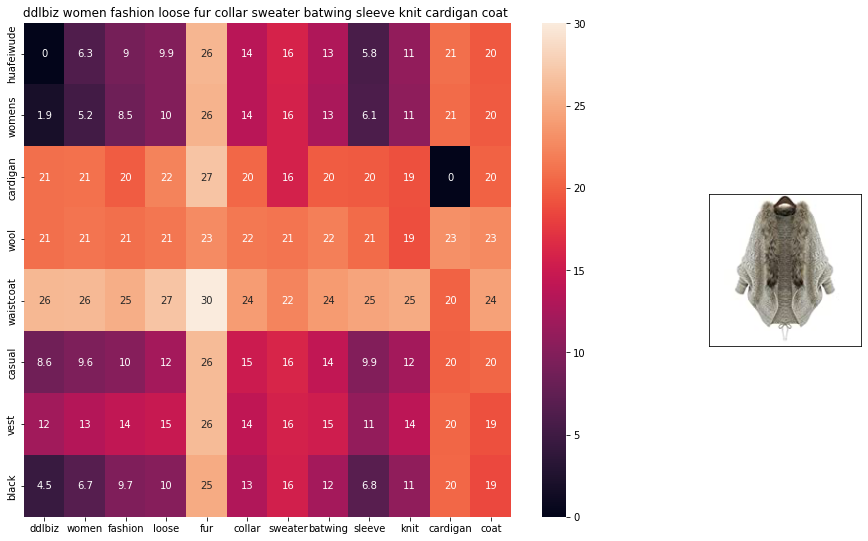

ASIN : B01MY76AQJ
Brand : DDLBiz
euclidean distance from input : 4.408304


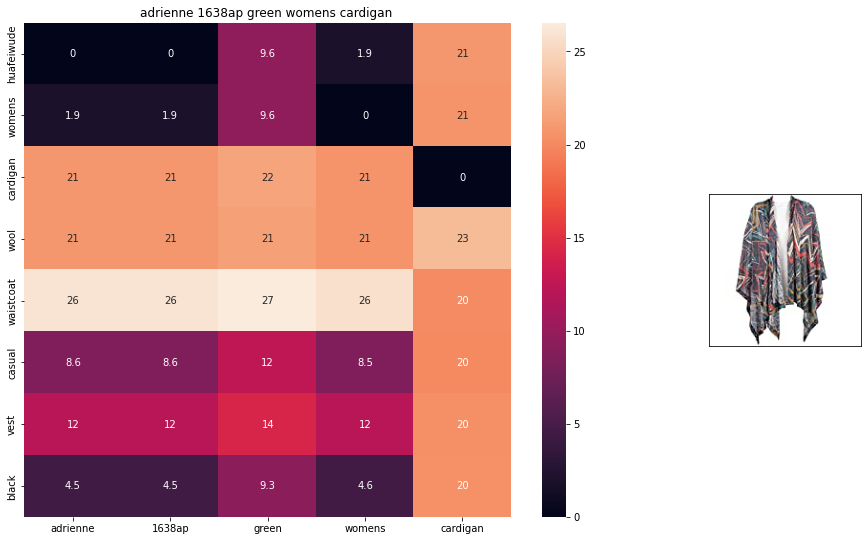

ASIN : B00O1HWO5W
Brand : Liuqiuhu
euclidean distance from input : 4.422664


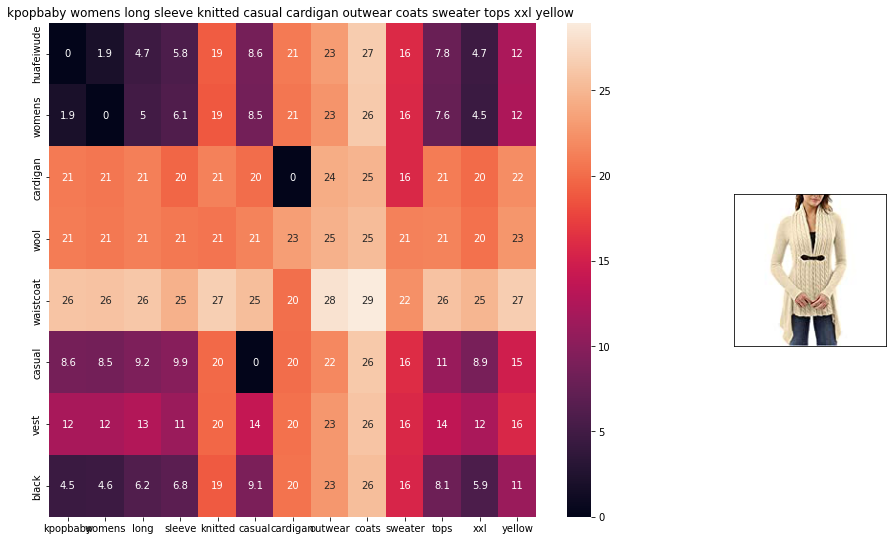

ASIN : B074LCPJJZ
Brand : KpopBaby
euclidean distance from input : 4.499772


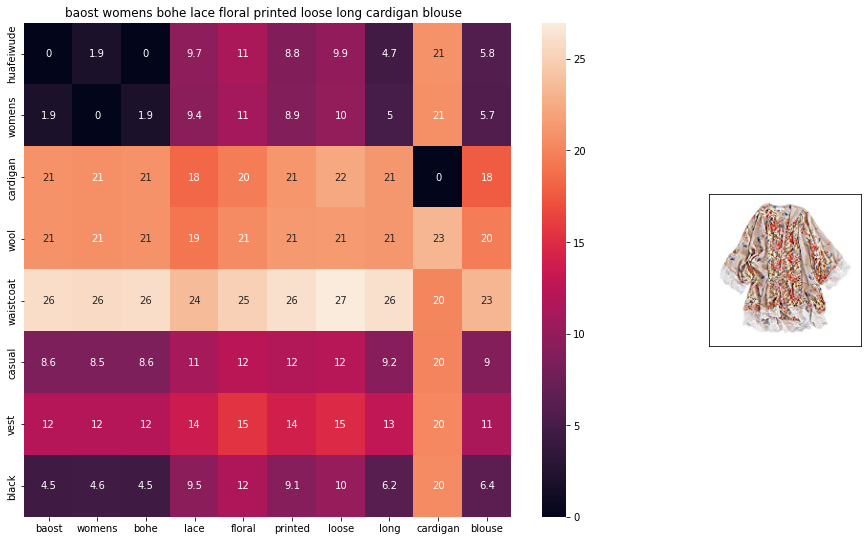

ASIN : B01GTA9352
Brand : Baost
euclidean distance from input : 4.5200267


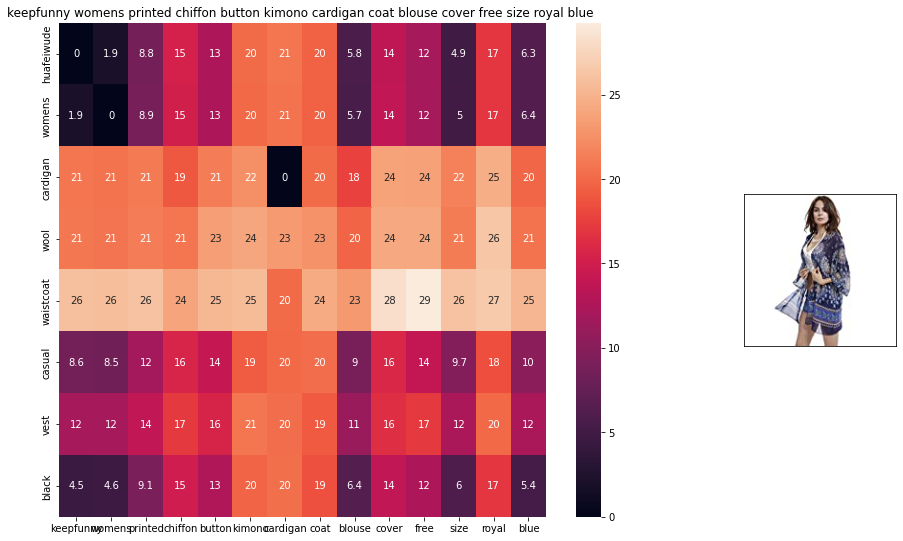

ASIN : B01IV2EEAK
Brand : KEEPFUNNY
euclidean distance from input : 4.5225873


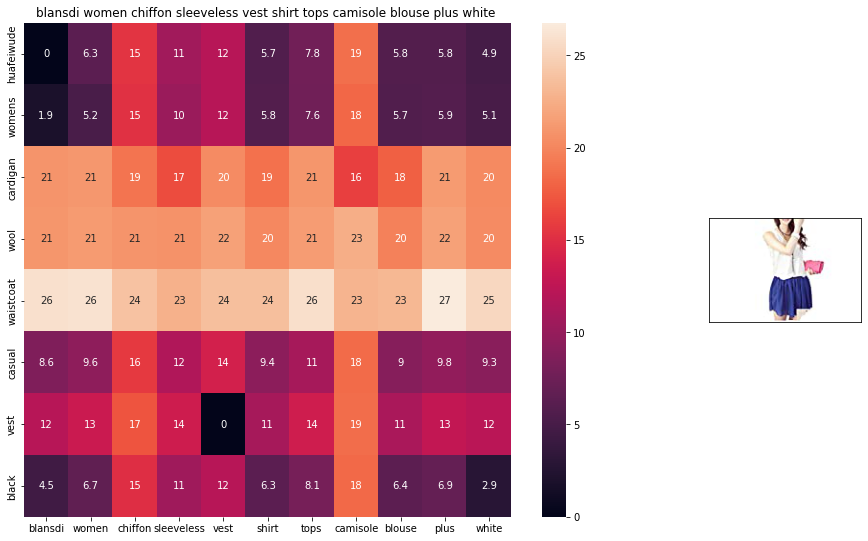

ASIN : B01AYVHQE2
Brand : Blansdi
euclidean distance from input : 4.534905


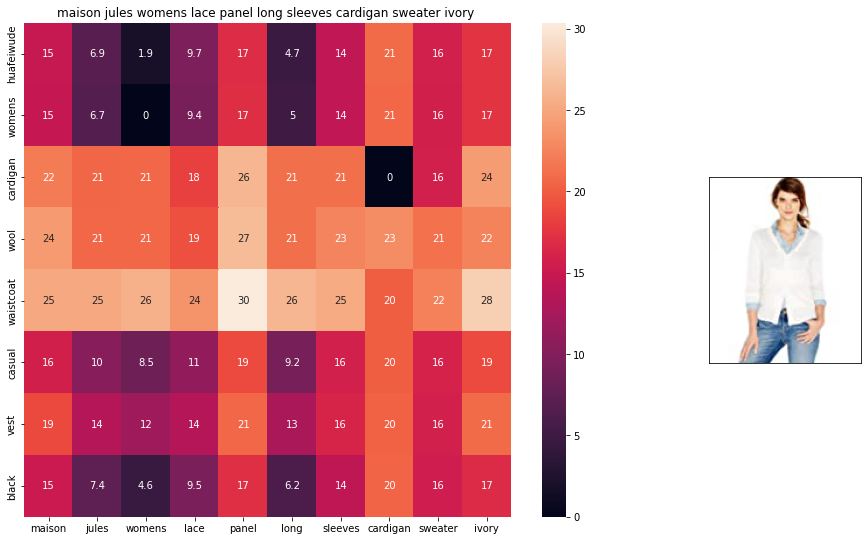

ASIN : B01DOKN4WS
Brand : Maison Jules
euclidean distance from input : 4.535721


In [ ]:
plotly.offline.init_notebook_mode(connected=True)
def weighted_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    pairwise_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    
    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)
        

weighted_w2v_model(12566, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j

## Weighted similarity using brand and color.

In [ ]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [ ]:
def heat_map_w2v_brand(sentence1, sentence2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentence1 : title1, input apparel
    # sentence2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax1.set_title(sentence2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

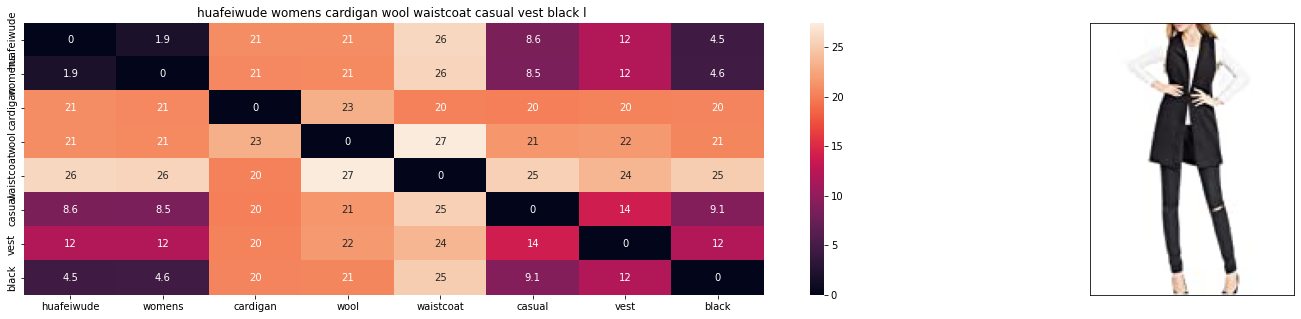

ASIN : B01MT96PXZ
Brand : Huafeiwude
euclidean distance from input : 0.0


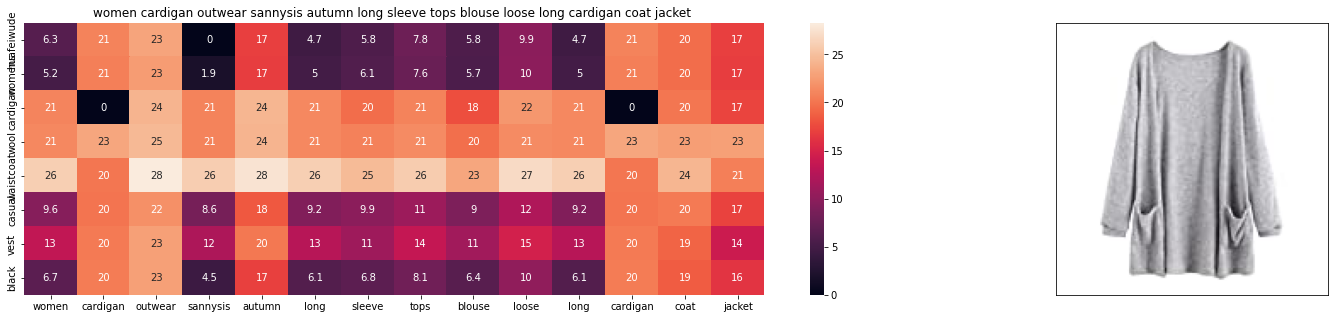

ASIN : B07473KFK1
Brand : Sannysis
euclidean distance from input : 2.8984806060791017


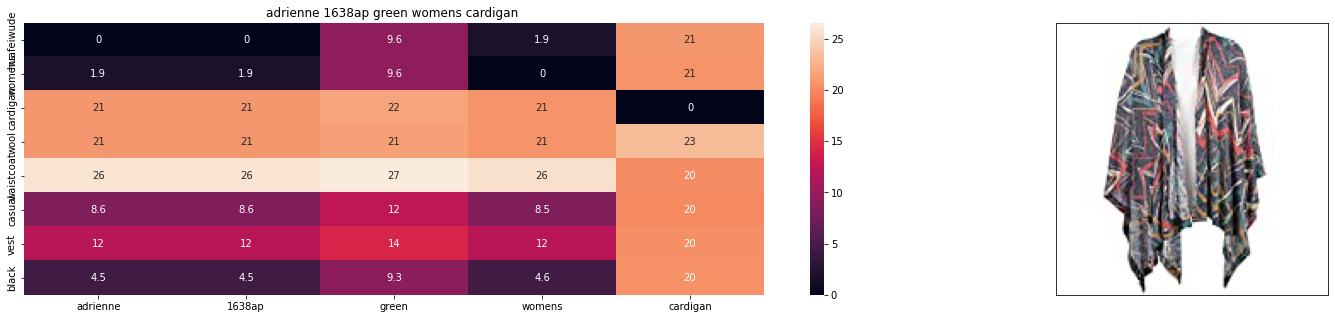

ASIN : B00O1HWO5W
Brand : Liuqiuhu
euclidean distance from input : 2.9184389116186766


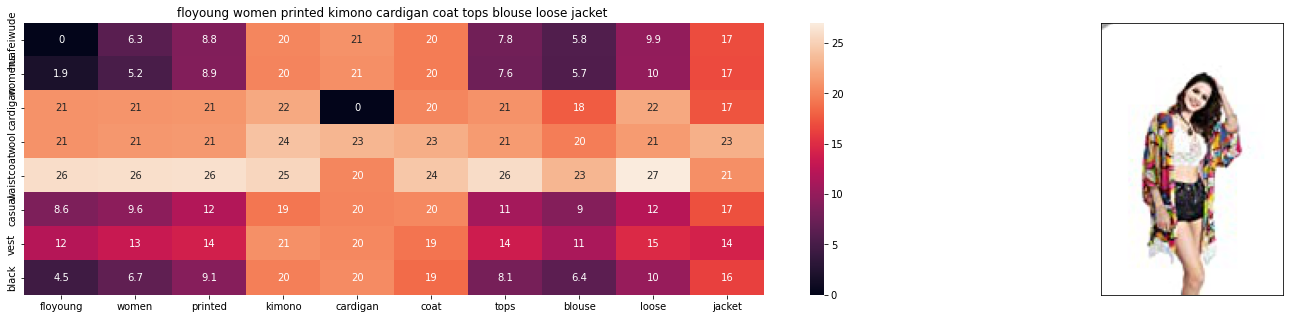

ASIN : B01D6EUG3W
Brand : FloYoung
euclidean distance from input : 2.9966798782348634


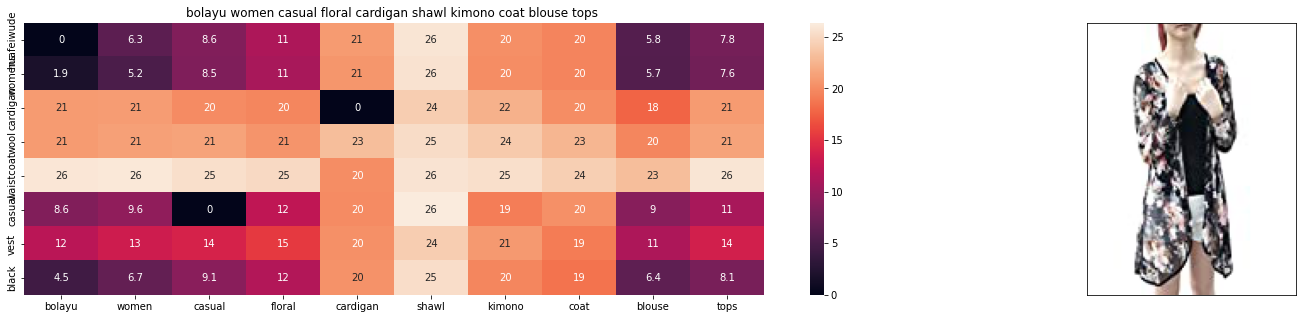

ASIN : B01F6UHWEU
Brand : Bolayu
euclidean distance from input : 3.0006389619726805


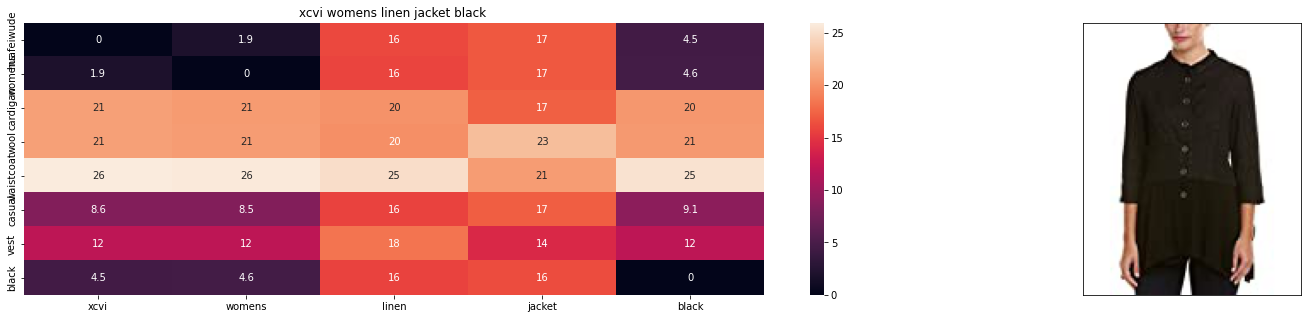

ASIN : B01M31Q4Z0
Brand : XCVI
euclidean distance from input : 3.0484086992163326


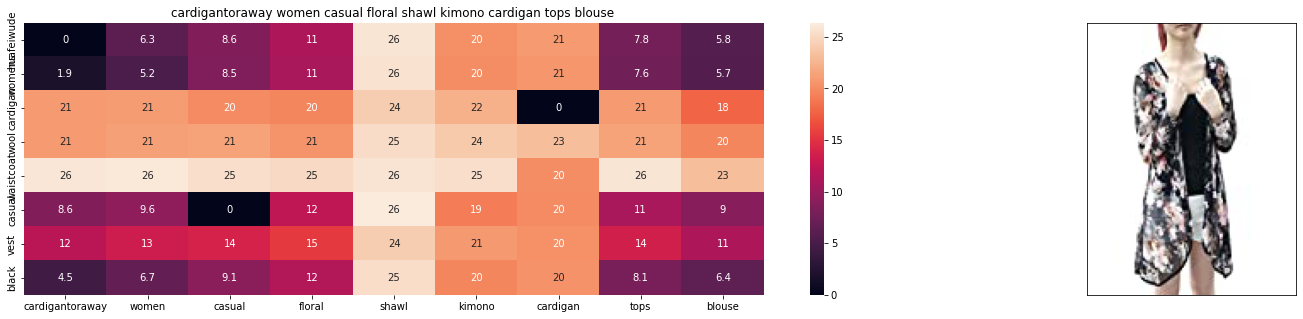

ASIN : B01CZMPCY4
Brand : Toraway
euclidean distance from input : 3.050865936459985


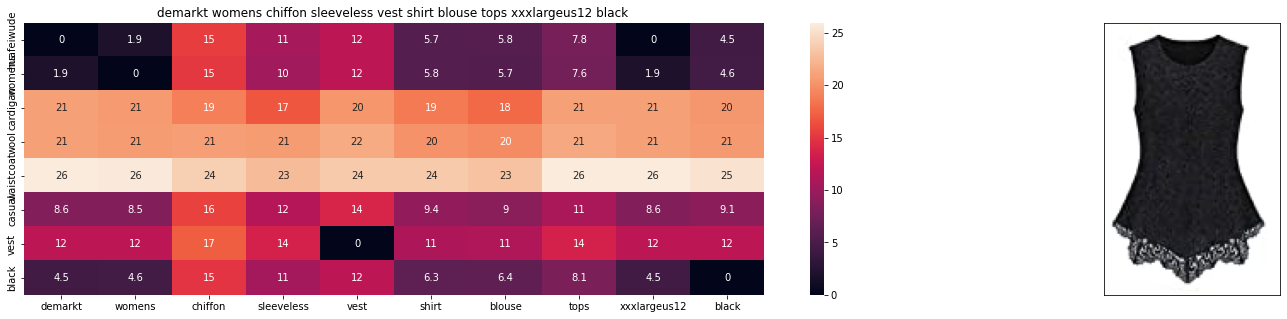

ASIN : B00JKCQZJE
Brand : Demarkt
euclidean distance from input : 3.081585693540063


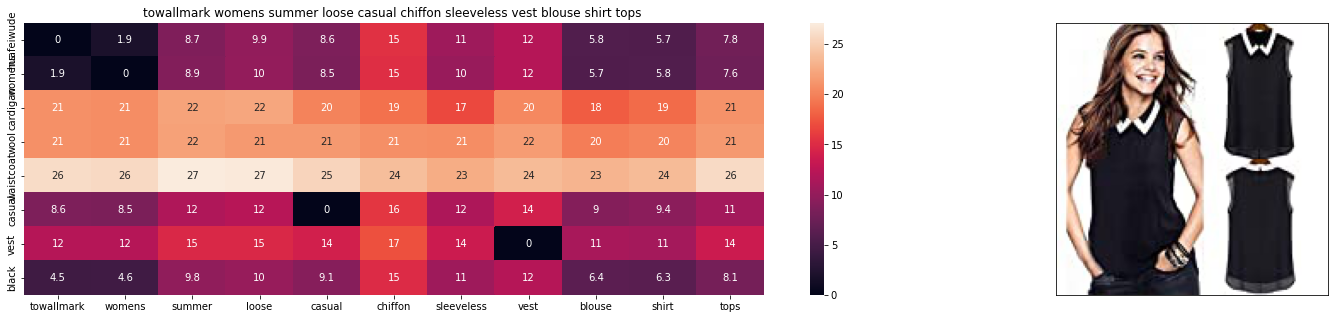

ASIN : B00QGEJ3MA
Brand : Towallmark
euclidean distance from input : 3.0982917787451414


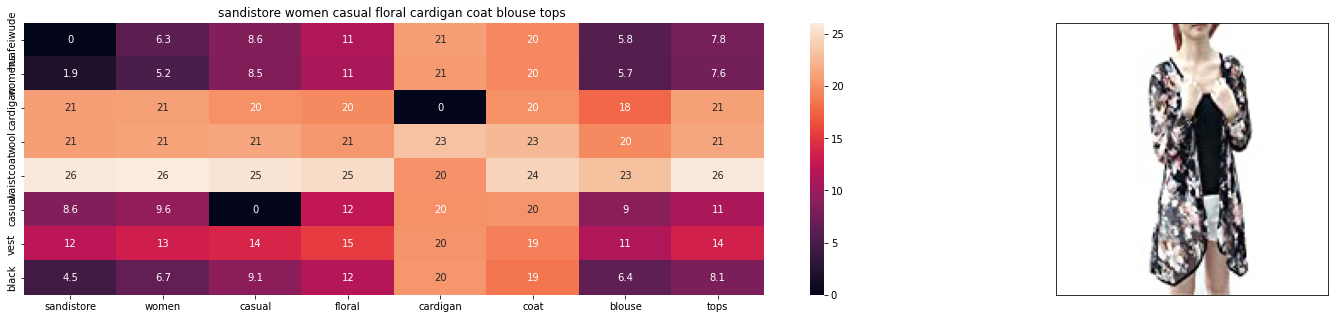

ASIN : B01AVX8IOU
Brand : Sandistore
euclidean distance from input : 3.1044492795824143


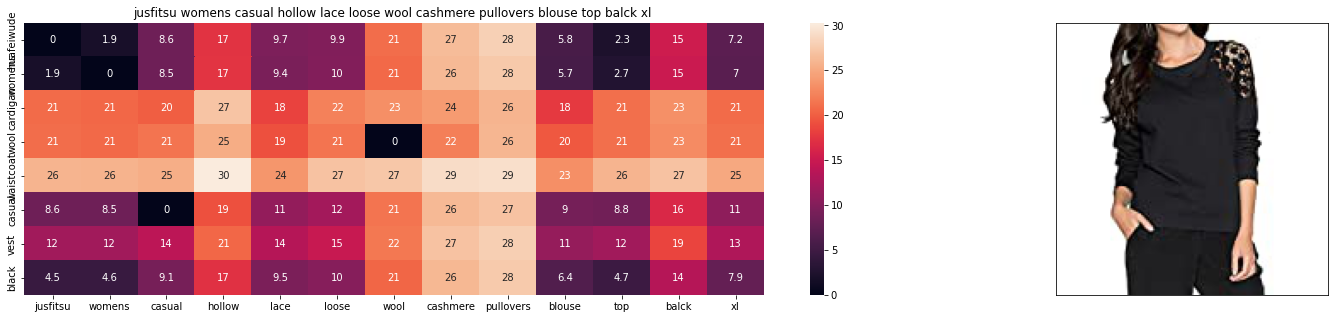

ASIN : B01N96GX38
Brand : Jusfitsu
euclidean distance from input : 3.1124135972876217


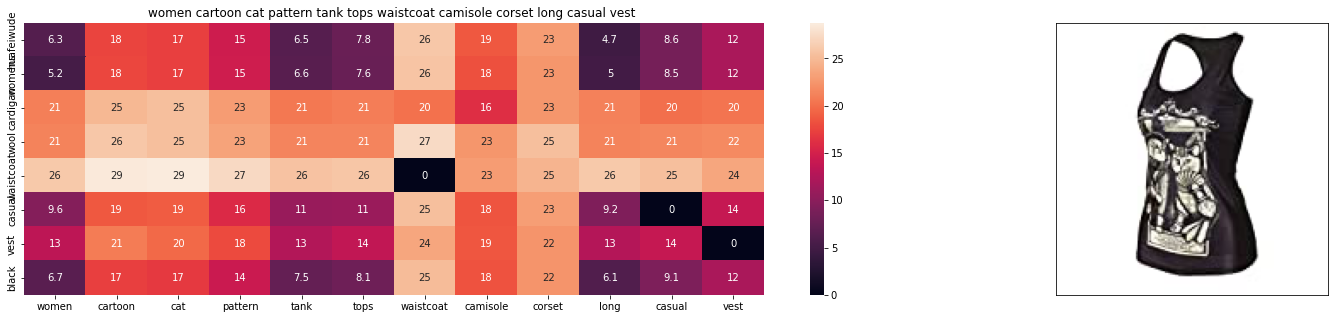

ASIN : B011R13YBM
Brand : Huayang
euclidean distance from input : 3.1135442733764647


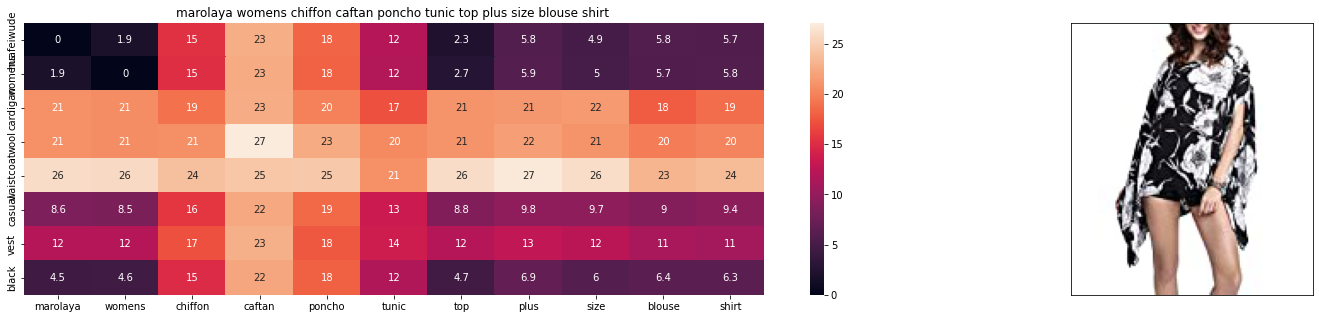

ASIN : B01CE40UW2
Brand : Marolaya
euclidean distance from input : 3.126744651975122


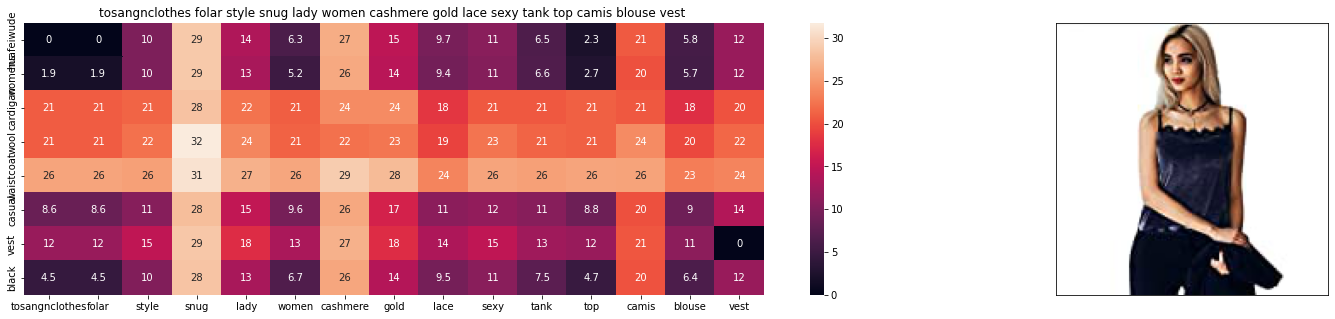

ASIN : B06XFRDH4J
Brand : Tosangn_Clothes
euclidean distance from input : 3.1292724611181884


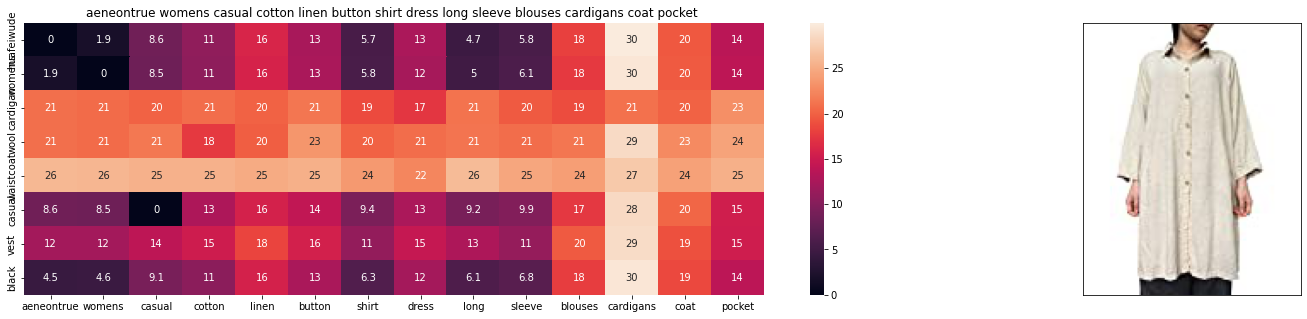

ASIN : B074V1K5QJ
Brand : Aeneontrue
euclidean distance from input : 3.1459396436571216


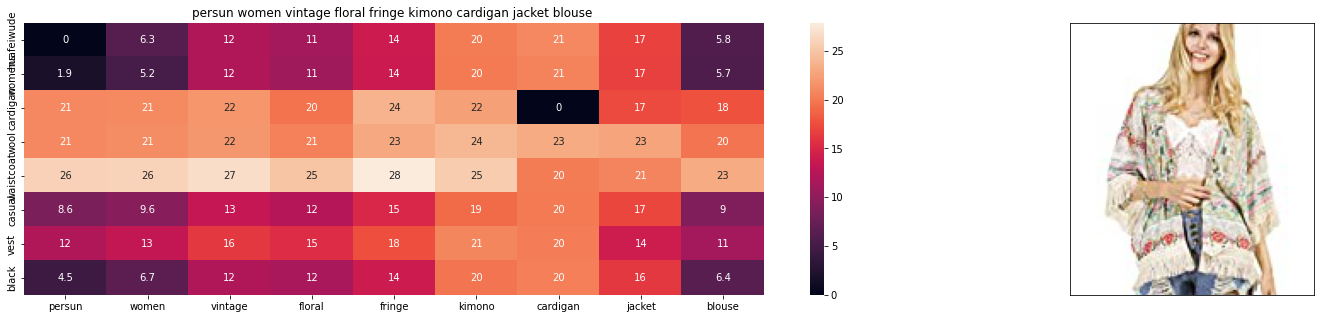

ASIN : B00Y26RSRQ
Brand : Persun
euclidean distance from input : 3.1488262176513673


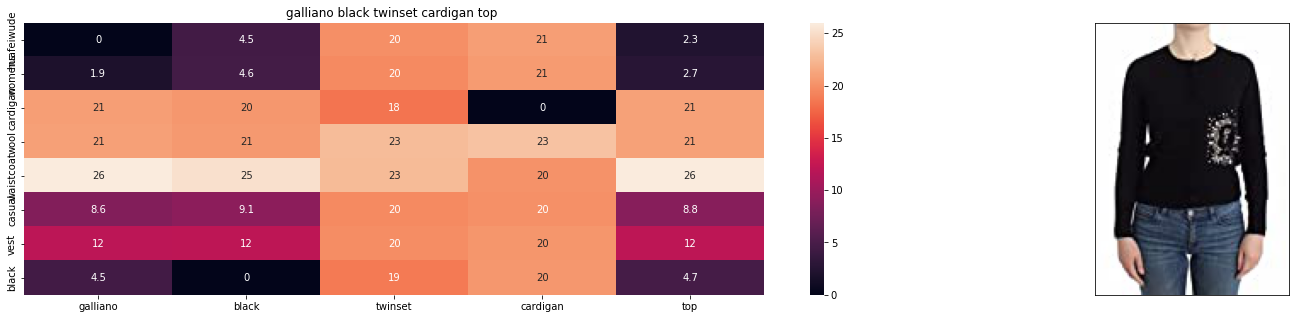

ASIN : B074G57HQJ
Brand : Galliano
euclidean distance from input : 3.158188819885254


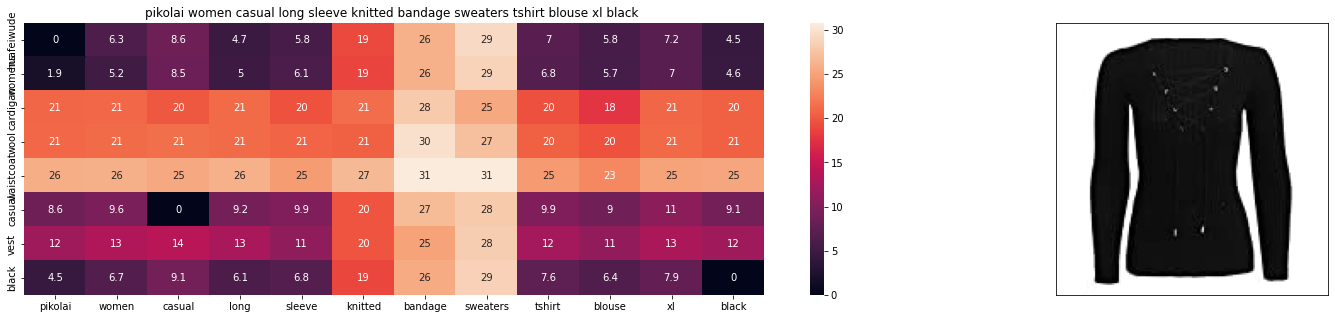

ASIN : B01LZ2B1HT
Brand : Pikolai
euclidean distance from input : 3.159334373654809


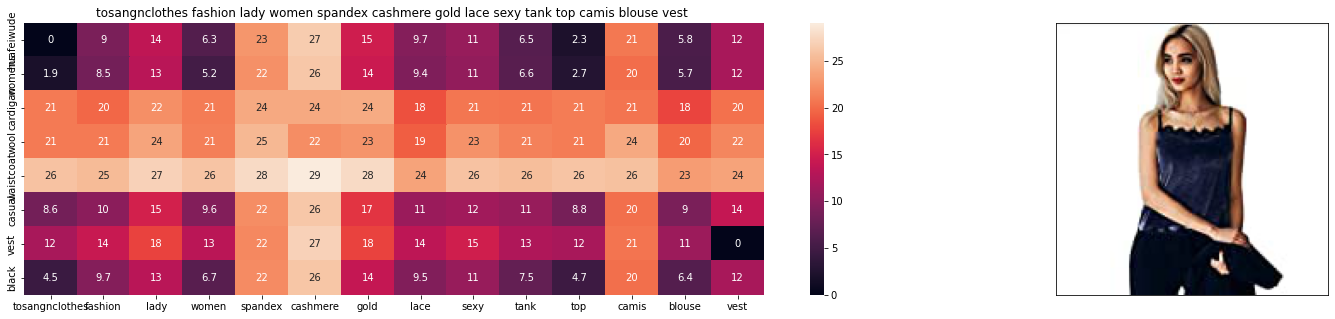

ASIN : B06XFFQLPL
Brand : Tosangn_Clothes
euclidean distance from input : 3.1688568117041256


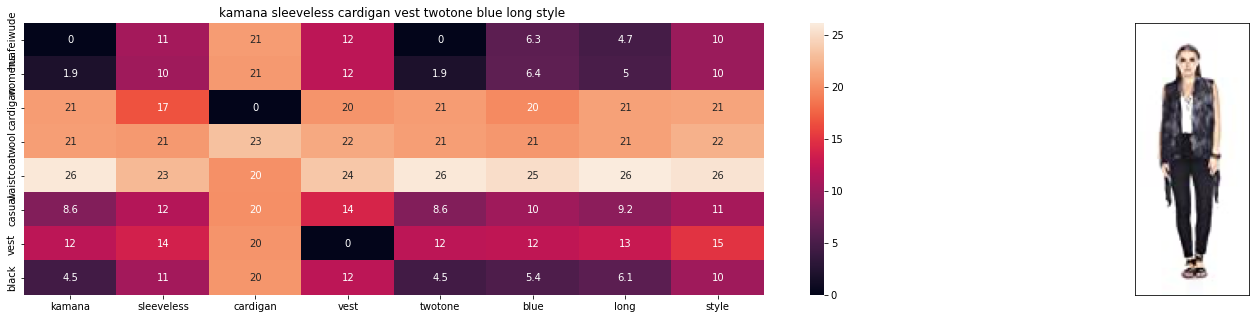

ASIN : B0751686K7
Brand : Kamana
euclidean distance from input : 3.177324751152331


In [ ]:
plotly.offline.init_notebook_mode(connected=True)
def idf_w2v_brand(doc_id, w1, w2, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist)/float(w1 + w2)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

idf_w2v_brand(12566, 5, 5, 20)
# in the heat map, each cell contains the euclidean distance between words i, j

## Using Keras and Tensorflow to extract features

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

ModuleNotFoundError: No module named 'keras'

## Visual features based product similarity

In [ ]:


# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'images2/'
nb_train_samples = 16042
epochs = 50
batch_size = 1


def save_bottlebeck_features():
    
    #Function to compute VGG-16 CNN for image feature extraction.
    
    asins = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    for i in generator.filenames:
        asins.append(i[2:-5])

    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))
    
    np.save(open('16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)
    np.save(open('16k_data_cnn_feature_asins.npy', 'wb'), np.array(asins))
    

save_bottlebeck_features()


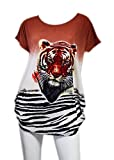

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 6.031566e-06
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


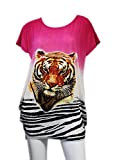

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 30.05017
Amazon Url: www.amzon.com/dp/B00JXQASS6


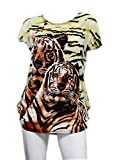

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 41.261116
Amazon Url: www.amzon.com/dp/B00JXQCUIC


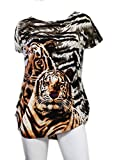

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 44.000156
Amazon Url: www.amzon.com/dp/B00JXQCWTO


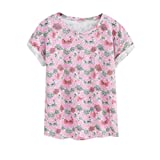

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 47.38248
Amazon Url: www.amzon.com/dp/B071FCWD97


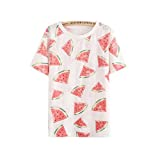

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 47.71842
Amazon Url: www.amzon.com/dp/B01JUNHBRM


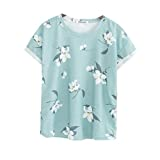

Product Title:  kawaii pastel tops tees baby blue flower design 
Euclidean Distance from input image: 47.90206
Amazon Url: www.amzon.com/dp/B071SBCY9W


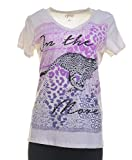

Product Title:  edv cheetah run purple multi xl 
Euclidean Distance from input image: 48.046482
Amazon Url: www.amzon.com/dp/B01CUPYBM0


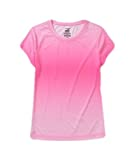

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 48.101837
Amazon Url: www.amzon.com/dp/B01F7PHXY8


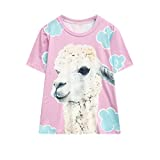

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Euclidean Distance from input image: 48.118866
Amazon Url: www.amzon.com/dp/B01I80A93G


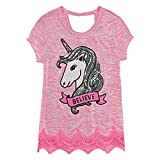

Product Title:  miss chievous juniors striped peplum tank top medium shadowpeach 
Euclidean Distance from input image: 48.13122
Amazon Url: www.amzon.com/dp/B0177DM70S


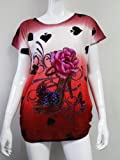

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Euclidean Distance from input image: 48.16945
Amazon Url: www.amzon.com/dp/B00JV63QQE


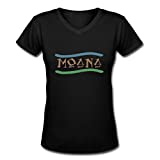

Product Title:  moana logo adults hot v neck shirt black xxl 
Euclidean Distance from input image: 48.256786
Amazon Url: www.amzon.com/dp/B01LX6H43D


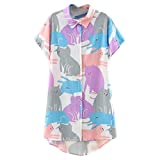

Product Title:  abaday multicolor cartoon cat print short sleeve longline shirt large 
Euclidean Distance from input image: 48.265686
Amazon Url: www.amzon.com/dp/B01CR57YY0


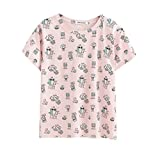

Product Title:  kawaii cotton pastel tops tees peach pink cactus design 
Euclidean Distance from input image: 48.362602
Amazon Url: www.amzon.com/dp/B071WYLBZS


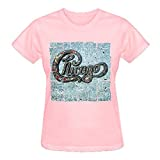

Product Title:  chicago chicago 18 shirt women pink 
Euclidean Distance from input image: 48.383606
Amazon Url: www.amzon.com/dp/B01GXAZTRY


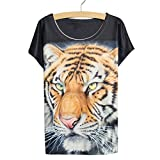

Product Title:  yichun womens tiger printed summer tshirts tops 
Euclidean Distance from input image: 48.449356
Amazon Url: www.amzon.com/dp/B010NN9RXO


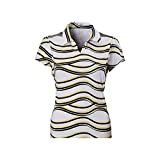

Product Title:  nancy lopez whimsy short sleeve  whiteblacklemon drop  xs 
Euclidean Distance from input image: 48.47889
Amazon Url: www.amzon.com/dp/B01MPX6IDX


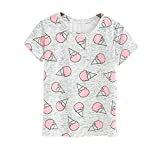

Product Title:  womens tops tees pastel peach ice cream cone print 
Euclidean Distance from input image: 48.557957
Amazon Url: www.amzon.com/dp/B0734GRKZL


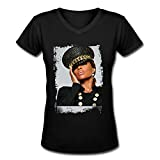

Product Title:  uswomens mary j blige without tshirts shirt 
Euclidean Distance from input image: 48.614372
Amazon Url: www.amzon.com/dp/B01M0XXFKK


In [15]:
# load the features and corresponding ASINS info.
plotly.offline.init_notebook_mode(connected=True)
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('C:/Users/esraj/OneDrive/Documents/Case Studies/My case studies/Amazon/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])


from IPython.display import display, Image, SVG, Math, YouTubeVideo


# get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

get_similar_products_cnn(12566, 20)


## Conclusion

#### Product Title based recommendation of products
- In the Bag of Words Model, while querying the specific product, we get a euclidean similarity of '0', and also we can observe the first recommended product's euclidean distance is 2.645 which is good, also we can see further, the distance is not increasing so much on other recommended products.

- Next, we try the TF-IDF model, the euclidean distance is less than '2' for recommended products, which is pretty good and better than the Bag of Words model.

- Then, implemented IDF only model, the first recommended product's distance is more than 15, so obviously it is performing worse than my previous models. 

- Now, I have used the Average Word2vec model, which performs very well than the TF-IDF model with a distance of less than one for my first recommended product.

- In this step, I have implemented IDF weighted Word2Vec, which is quite low in performance compared to Average Word2Vec. 


#### Brand and color based recommendation of products
- Implemented a model using IDF Word2Vec model using brand and color name, we can observe the euclidean distance is less 2.89 which is good compared to Bag of Words Model. 


#### Deep Learning-based recommendation of products
- I have decided to try deep learning, to check how it performs. So, I have implemented one of the Convolutional Neural Networks (CNN) called VGGNet-16. We are giving images as input, where we can observe that it automatically learns the features of the images, the euclidean distance of the first recommended product is 6.03e-06, which is so small. So, we can visualize that the deep learning model performs very well than all other previous models. 